# DATA2 -  RF - baseline - Without standarization

## Features:

1. 'AGE', 
1. 'RAVLT_immediate'
1. 'AVDEL30MIN_neuro'
1. 'AVDELTOT_neuro' 
1. 'TRAASCOR_neuro' 
1. 'TRABSCOR_neuro'
1. 'CATANIMSC_neuro' 
1. 'GDTOTAL_gds'
1. 'LRHHC_n_long'
1. 'LRLV_n_long'
1. 'FAQ'


1. 'Subgroup\_'
1. 'Subgroup\_num\_'
1. 'Usage\_'


---

**Resources**
1. DATA
    1. [data/data2](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2) - csv files downloaded from ADNI,
    1. [data/data2_FS](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2_FS) - FS result csv files,
    1. [data_zip/20201109_data2_file_versions](https://github.com/MMIV-ML/MCI-subgroups/blob/master/data/data_zip/20201109_data2_file_versions.pdf) - download ADNI web page screen shoot taken for downaloaded csv files (some of file neames are printed with dates),
1. RESULTS
    1. [results/20210420](https://github.com/MMIV-ML/MCI-subgroups/tree/master/results/20210420) - result folder,
    1. [results/202100420/README.md](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/README.md) - short description,
1. GOOGLE DRIVE
    1. [slides](https://docs.google.com/presentation/d/1aEK7M5BPe0RxWYskzQCEDbT4Mf-4mRRqQ5uJ_YuqRzg/edit#slide=id.p) - link to google slides (**OUT OF DATE, MUST BE UPDATED !!!**),
    1. [GoogleDrive](https://drive.google.com/drive/folders/1r8l2R88-0T8Xahk30iAgjBCWXvV1R2J-) - the main google drive slide folder,
1. GIT HUB
    1. [GitHub](https://github.com/MMIV-ML/MCI-subgroups) - the main repo folder,
1. [An overview](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/3.xx_RF_bl_comparison.pdf)


The latest changes (ver. 0.16):

    v 0.16
    
        - save, load `train` and `val` test split from a file. For a different fold number e.g. k={10, 20, 50, ...}
        
    v 0.15
    
    - feature perumtation function from scratch -> moved to the separate notebook: 3.02-data2-RF-bl-permutation.ipynb,
    - Conf_mat_ results (TP, TN, FP, FN), -> saved to external csv files,
    - Replace manual CV scores with built-in functions,
    - CV folds split loaded from file (to use in `bl` and `long`).
    
   *Created: 2021.03.18 / Updated: 2021.10.07*
   
---

#### IMPORTS

In [73]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [74]:
import eli5
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import Image
from IPython.display import SVG #display, 
from eli5.sklearn import PermutationImportance

In [75]:
import mci_info as minfo
import mci_utils as mutils
# import mci_freesurfer as mfs
import mci_rf_bl as mrfbl

In [76]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence

#### GLOBAL PATH VARIABLES

In [77]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'data/data2'
DATA_DIR_FS = ROOT_DIR / 'data/data2_FS'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results/20201110'
# Results folder
RESULTS_DIR = ROOT_DIR/'results/20211111' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#### INSTALLED PACKAGES INFO

In [78]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels',
                'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: MMIV-ML-Alienware-m17
Operating system: Linux, 64bit

Python path: /home/ingrid/miniconda3/envs/mci/bin/python
Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]



,module,version
4,eli5,0.11.0
6,ipywidgets,7.6.5
10,matplotlib,3.4.3
13,numpy,1.19.5
15,pandas,1.3.4
16,pdpbox,0.2.1
20,scipy,1.5.4
21,seaborn,0.11.2
23,sklearn,0.23.2
24,statsmodels,0.13.0


---

## GLOBAL VARIABLES TO UPDATE IN EACH NOTEBOOK SEPARATELY!!! 

In [79]:
# features to feed the current model
FEATURES = ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 
            'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long',
            'FAQ', 'Subgroup_', 'Subgroup_num_', 'Usage_'] 
FEATURE_NUMBER=len(FEATURES)
print(f'Number of selected features: {FEATURE_NUMBER}')


# Filename prefixes used to save all results (tables, images, ...)
FILE_NAME_PREFIX = '3.14_copy4Alexandra_K50_RF_'
FILE_NAME_NUMBER = FILE_NAME_PREFIX.split('_')[0]

# Filename to load/save model. 
#Used if we load model from file with different name.
FILE_NAME_WITH_GS_MODEL_TO_LOAD = '3.14_copy4Alexandra_K50_RF-master_'
# For model name the same as the current file prefix
# FILE_NAME_WITH_GS_MODEL_TO_LOAD = FILE_NAME_PREFIX

# random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# folds 
FOLDS = 50
# cross-validation fold split number to save in a csv file
FOLDS_LIST = [10, 20, 50]

# display all stuff
VERBOSE = True

Number of selected features: 14


---

## LOAD `CSV BASELINE` FILE

Load baseline csv file and restrict the whole bunch of avaliable features to those defined in the variable `FEATURES` that is defined above.

In [80]:
bl_name = CURRENT_DATA_DIR / 'bl.csv'
bl_loaded = pd.read_csv(bl_name, index_col=0)

bl_sel_feat = bl_loaded[FEATURES]

print(f'Subjects: \t{bl_sel_feat.shape[0]}')
print(f'Columns: \t{bl_sel_feat.shape[1]}')

Subjects: 	708
Columns: 	14


#### DISPLAY THE NAN VALUES IN THE WHOLE DATA FRAME

Insepect `NaN` values in the loaded dataframe.

In [81]:
if VERBOSE:
    print(bl_sel_feat.isnull().sum())
    bl_sel_feat.shape

AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
LRHHC_n_long        14
LRLV_n_long         14
FAQ                  4
Subgroup_            0
Subgroup_num_        0
Usage_               0
dtype: int64


### SPLIT BETWEEN TRAIN AND TEST SUBSETS

In [82]:
bl_train = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'train']
bl_test = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'test']

# a list of both sets, to ease further manipulation
bl_sets = [['Train set', bl_train], ['Test set', bl_test]]

---

## TRAIN / TEST SETS SHORT INFO

In [83]:
if VERBOSE: 
    print('Subjects in:')
    for name, bl in bl_sets:
        print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/bl_sel_feat.shape[0] * 100:.0f}%)')

    print('\n\nSubjects in each subgroup (with NaN included):\n')
    for name, bl in bl_sets:
        print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')

Subjects in:
	Train set:	566 (80%)
	Test set:	142 (20%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    305
cAD     261

*** Test set ***
sMCI    76
cAD     66



#### PRINT COLUMN NAMES INCLUDED IN BOTH SETS

In [84]:
minfo.included_feature_info(bl_train, pattern='adni-neuro-gds-long-_')

Total number of columns: 14



,adni (#3),neuro (#5),gds (#1),long (#2),ours (#3)
0,AGE,AVDEL30MIN_neuro,GDTOTAL_gds,LRHHC_n_long,Subgroup_
1,FAQ,AVDELTOT_neuro,,LRLV_n_long,Subgroup_num_
2,RAVLT_immediate,CATANIMSC_neuro,,,Usage_
3,,TRAASCOR_neuro,,,
4,,TRABSCOR_neuro,,,


---

## COUNT `NaN` VALUES IN TRAIN AND TEST SETS

In [85]:
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 566 rows) ***
AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
LRHHC_n_long        13
LRLV_n_long         13
FAQ                  3
Subgroup_            0
Subgroup_num_        0
Usage_               0

Rows in Train set: 566



*** NaN values in TEST SET set (out of 142 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
LRHHC_n_long        1
LRLV_n_long         1
FAQ                 1
Subgroup_           0
Subgroup_num_       0
Usage_              0

Rows in Test set: 142





#### DISPLAY ALL SUBJECTS THAT CONTAIN `NaN` VALUES (BOTH SETS)

In [86]:
if VERBOSE:
    for name, bl in bl_sets:
        num = bl.isnull().sum().sum()
        #idx = bl.isnull().index
        print(f'*** {name.upper()} ***')
        display(bl.loc[bl.isnull().any(axis=1)].head(num))
        print()

*** TRAIN SET ***


,AGE,RAVLT_immediate,AVDEL30MIN_neuro,AVDELTOT_neuro,TRAASCOR_neuro,TRABSCOR_neuro,CATANIMSC_neuro,GDTOTAL_gds,LRHHC_n_long,LRLV_n_long,FAQ,Subgroup_,Subgroup_num_,Usage_
20,83.3,21.0,0.0,7.0,34.0,NaN,16.0,2.0,0.003313,0.018348,6.0,sMCI,0,train
130,70.3,22.0,2.0,13.0,60.0,170.0,5.0,2.0,0.004205,0.040182,NaN,sMCI,0,train
1883,69.1,32.0,0.0,11.0,60.0,93.0,12.0,1.0,0.003544,0.011873,NaN,cAD,1,train
2284,69.0,29.0,1.0,11.0,54.0,NaN,11.0,5.0,0.004512,0.021344,0.0,sMCI,0,train
2948,61.7,21.0,0.0,6.0,57.0,NaN,10.0,2.0,0.005170,0.006507,4.0,sMCI,0,train
3437,75.2,27.0,3.0,10.0,22.0,112.0,22.0,0.0,NaN,NaN,9.0,sMCI,0,train
3523,81.6,28.0,3.0,10.0,61.0,170.0,14.0,0.0,NaN,NaN,1.0,sMCI,0,train
3547,76.6,33.0,8.0,14.0,40.0,NaN,13.0,3.0,NaN,NaN,2.0,sMCI,0,train
3639,66.7,55.0,11.0,14.0,33.0,NaN,28.0,3.0,0.005139,0.011287,0.0,sMCI,0,train
3652,71.0,20.0,0.0,8.0,60.0,176.0,20.0,1.0,NaN,NaN,1.0,sMCI,0,train



*** TEST SET ***


,AGE,RAVLT_immediate,AVDEL30MIN_neuro,AVDELTOT_neuro,TRAASCOR_neuro,TRABSCOR_neuro,CATANIMSC_neuro,GDTOTAL_gds,LRHHC_n_long,LRLV_n_long,FAQ,Subgroup_,Subgroup_num_,Usage_
2119,55.1,31.0,2.0,8.0,23.0,72.0,16.0,1.0,0.005315,0.010229,NaN,cAD,1,test
3926,63.0,32.0,5.0,15.0,35.0,105.0,21.0,2.0,NaN,NaN,3.0,sMCI,0,test


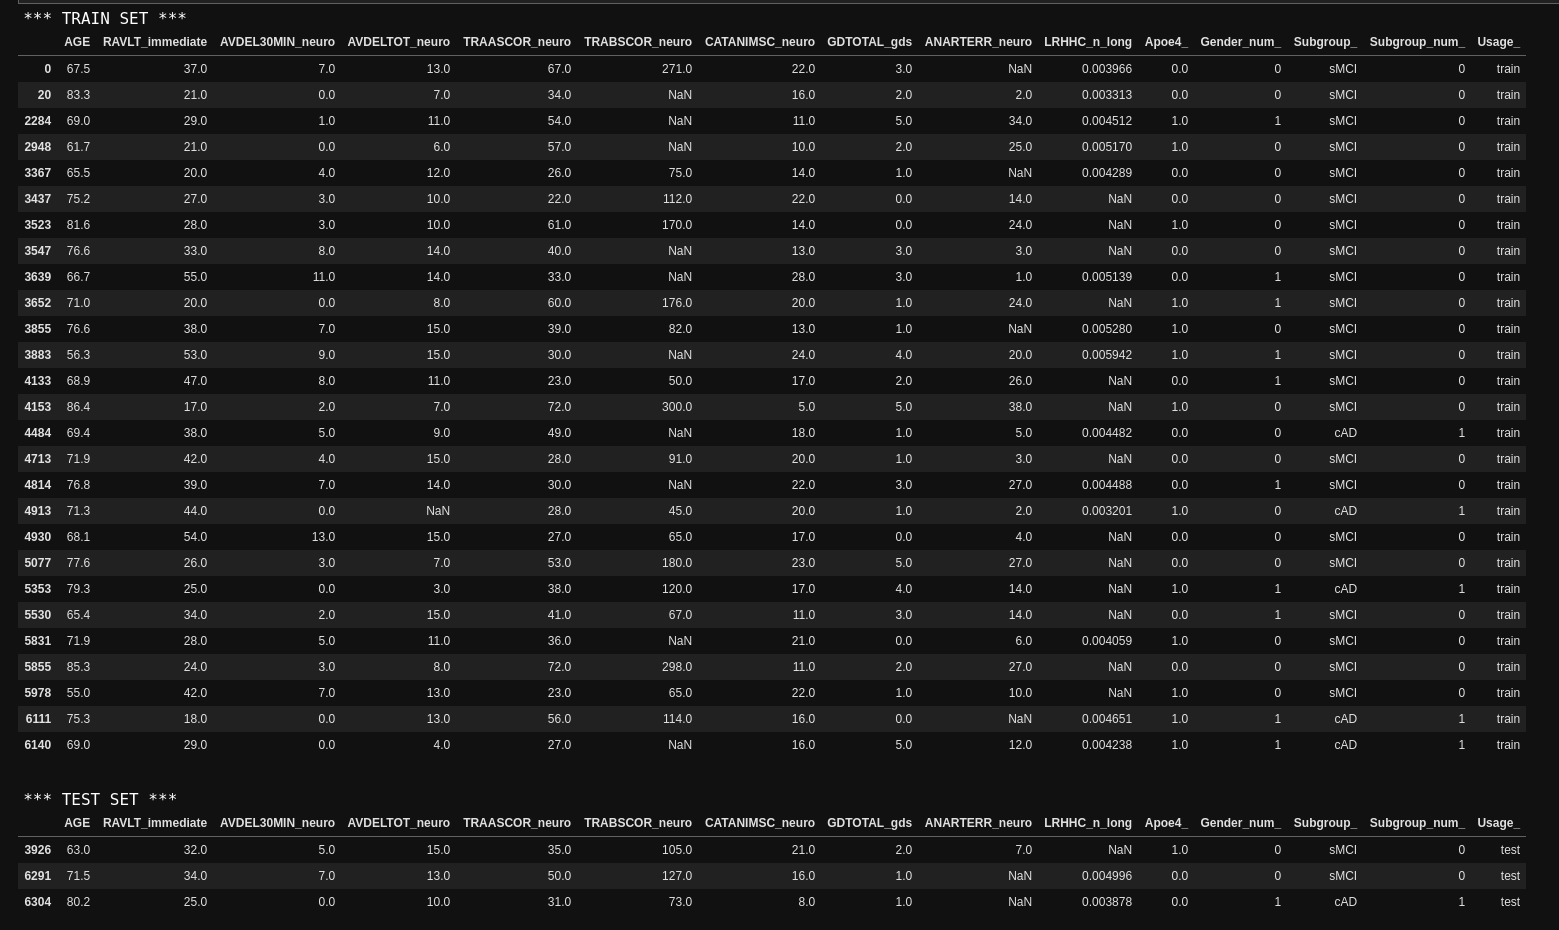

In [87]:
if VERBOSE:
    display(Image(filename="figs/assets/NaN_subjects.png", width=900))

## DROP `NaN` VALUES IN TRAIN AND TEST SETS (IF ANY)

In [88]:
print('\nSubjects number in both sets AFTER dropping NaN values:\n')
for name, bl in bl_sets:        
    bl.dropna(axis='rows', inplace=True)
    print(f' - {name}: {bl.shape[0]}\n')


Subjects number in both sets AFTER dropping NaN values:

 - Train set: 540

 - Test set: 140



#### COUNT `NaN` VALUES IN TRAIN AND TEST SETS (AFTER DROP `NaN` ROWS) 

In [89]:
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 540 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
LRHHC_n_long        0
LRLV_n_long         0
FAQ                 0
Subgroup_           0
Subgroup_num_       0
Usage_              0

Rows in Train set: 540



*** NaN values in TEST SET set (out of 140 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
LRHHC_n_long        0
LRLV_n_long         0
FAQ                 0
Subgroup_           0
Subgroup_num_       0
Usage_              0

Rows in Test set: 140





___

#### COUNT TRAIN / TEST  PERCENTAGE PROPORTION AFTER EXCLUDING NaN VALUES

In [90]:
print('Subjects in:')
for name, bl in bl_sets:
    print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/(bl_train.shape[0] + bl_test.shape[0]) * 100:.0f}%)')

print('\n\nSubjects in each subgroup (without NaN included):\n')
for name, bl in bl_sets:
    #print(f'*** {name} ***\n')
    mutils.textWrap(name)
    print()
    #print(f'{bl.Subgroup_.value_counts().to_string()}\n')
    #print(f'{bl.PTGENDER.value_counts().to_string()}\n')
    
    dfs = bl.Subgroup_.value_counts().rename_axis('Subgroup_').reset_index(name='#Nr')
    dfp = bl.PTGENDER.value_counts().rename_axis('PTGENDER').reset_index(name='#Nr')
    df = pd.concat([dfs,dfp],axis=1)
    display(df)
    

    cols1 = ['AGE']
    cols2 = ['PTGENDER'] 
    df1 = bl.groupby(['Subgroup_', 'PTGENDER'])
    a = df1[cols1].mean().round(2)
    c = df1[cols1].std().round(2)
    b = df1[cols2].count()
    
    df_abc = pd.concat([a,c,b],axis=1) 
    display(df_abc)

Subjects in:
	Train set:	540 (79%)
	Test set:	140 (21%)


Subjects in each subgroup (without NaN included):


#################
### Train set ###
#################



AttributeError: 'DataFrame' object has no attribute 'PTGENDER'

### SOME `SUBGROUP\_` STATISTICS

In [91]:
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, bl in bl_sets:
        mutils.textWrap(name)
        print(f'\nSubjects {bl.shape[0]}')
        
        for gr in ['sMCI', 'cAD']:
            print(f'\n*** {gr} ***')
            display(minfo.df_stats_info(bl[bl.Subgroup_ == gr]))

Basic statistics for features in both sets:

#################
### Train set ###
#################

Subjects 540

*** sMCI ***


,max.,mean,min.,std,val_range,NaN_Nr
AGE,91.400,73.198,55.900,7.489,35.500,0
RAVLT_immediate,67.000,36.902,13.000,10.828,54.000,0
AVDEL30MIN_neuro,15.000,4.968,0.000,3.980,15.000,0
AVDELTOT_neuro,15.000,11.235,0.000,3.175,15.000,0
TRAASCOR_neuro,148.000,39.421,13.000,16.358,135.000,0
TRABSCOR_neuro,300.000,109.856,33.000,60.193,267.000,0
CATANIMSC_neuro,32.000,17.740,6.000,5.167,26.000,0
GDTOTAL_gds,6.000,1.677,0.000,1.471,6.000,0
LRHHC_n_long,0.006,0.005,0.003,0.001,0.004,0
LRLV_n_long,0.076,0.026,0.005,0.013,0.071,0



*** cAD ***


,max.,mean,min.,std,val_range,NaN_Nr
AGE,88.300,73.961,55.200,6.964,33.100,0
RAVLT_immediate,67.000,28.831,11.000,7.846,56.000,0
AVDEL30MIN_neuro,15.000,1.922,0.000,2.613,15.000,0
AVDELTOT_neuro,15.000,9.314,0.000,3.552,15.000,0
TRAASCOR_neuro,150.000,44.867,17.000,19.999,133.000,0
TRABSCOR_neuro,300.000,134.184,40.000,72.247,260.000,0
CATANIMSC_neuro,35.000,15.851,5.000,4.885,30.000,0
GDTOTAL_gds,6.000,1.702,0.000,1.430,6.000,0
LRHHC_n_long,0.006,0.004,0.002,0.001,0.004,0
LRLV_n_long,0.065,0.027,0.006,0.012,0.059,0



################
### Test set ###
################

Subjects 140

*** sMCI ***


,max.,mean,min.,std,val_range,NaN_Nr
AGE,87.800,72.843,57.800,7.292,30.000,0
RAVLT_immediate,65.000,36.800,20.000,9.167,45.000,0
AVDEL30MIN_neuro,14.000,4.653,0.000,3.656,14.000,0
AVDELTOT_neuro,15.000,11.427,1.000,3.098,14.000,0
TRAASCOR_neuro,87.000,38.307,16.000,12.055,71.000,0
TRABSCOR_neuro,283.000,102.227,54.000,44.570,229.000,0
CATANIMSC_neuro,30.000,18.147,6.000,4.977,24.000,0
GDTOTAL_gds,5.000,1.813,0.000,1.281,5.000,0
LRHHC_n_long,0.007,0.004,0.003,0.001,0.004,0
LRLV_n_long,0.060,0.025,0.010,0.012,0.050,0



*** cAD ***


,max.,mean,min.,std,val_range,NaN_Nr
AGE,88.400,74.262,55.000,7.397,33.400,0
RAVLT_immediate,50.000,30.708,20.000,6.948,30.000,0
AVDEL30MIN_neuro,11.000,2.369,0.000,2.673,11.000,0
AVDELTOT_neuro,15.000,9.815,2.000,3.579,13.000,0
TRAASCOR_neuro,150.000,44.323,21.000,26.683,129.000,0
TRABSCOR_neuro,300.000,132.800,38.000,81.052,262.000,0
CATANIMSC_neuro,28.000,15.754,6.000,4.316,22.000,0
GDTOTAL_gds,4.000,1.431,0.000,1.199,4.000,0
LRHHC_n_long,0.006,0.004,0.003,0.001,0.003,0
LRLV_n_long,0.080,0.029,0.009,0.013,0.072,0




---

# CREATE X AND y

___

In [92]:
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_num_

# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_num_

# a list of both sets, to ease forfurther manipulation
X_sets = [['X train set', X_train], ['X test set', X_test]]
y_sets = [['y train set', y_train], ['y test set', y_test]]

In [93]:
print(X_test.shape)
print(X_train.shape)


(140, 14)
(540, 14)


# SAVING FOR PYCHARET #

In [94]:
pycharet = pd.concat([X_train, X_test])
print(pycharet.shape)
pycharet.to_csv(RESULTS_DIR / '3.14_pycharet_K50.csv')

(680, 14)


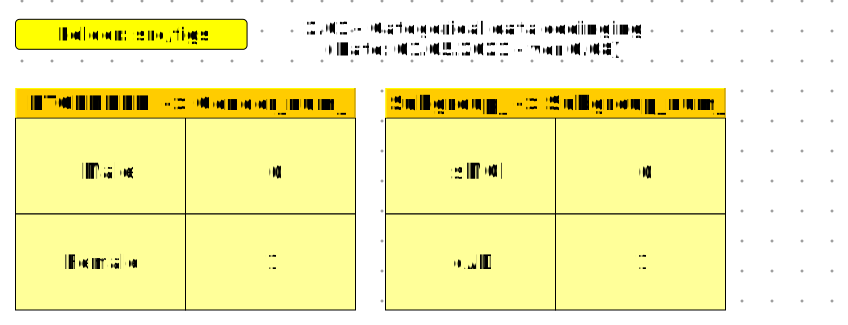

In [95]:
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

___

# PREPARE `CROSS-VALIDATION` FOLDS FOR FUTURES USE (E.G. WITH LONGITUDINAL DATA)

### SAVE `CROSS-VALIDATION` FOLDS TO A `CSV` FILE

To have the same split rules for `bl` and `long` analysies we prepare a csv file with splits between `train` and `test` sets for varius k, e.g. for `k={10,20,50}`.

In [96]:
save_kfolds = 1

if save_kfolds:
    df2 = pd.DataFrame(index=X_train.index)
    #df2['X_train_idx'] = X_train.index
    
    for fld in FOLDS_LIST:
        # prefix: SKF_
        skf = StratifiedKFold(n_splits=fld, shuffle=False)
        SPLITS = []

        # a table for each fold separately (10...20...50)
        df = pd.DataFrame(index=X_train.index)
        
        
        for k, (train_index, validation_index) in enumerate(skf.split(X_train,y_train)):
        #     X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
        #     y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
            SPLITS.append([train_index, validation_index])
            
            col_name = f'SKF_CV{fld}_F{k:0>2}_'
            df.loc[X_train.index[validation_index], col_name] = "val"
            df.loc[X_train.index[train_index], col_name] = "train"
            
        # a table to concatenate tables with folds -> concat([df10, df20, df50])
        df2 = pd.concat([df2,df], axis=1)  
    
    # save to a file
    kfolds_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_kfolds.csv'
    df2.to_csv(kfolds_csv_path)
    print(f'File saved to\n\t{kfolds_csv_path}')
    print()

File saved to
	/home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF__kfolds.csv



# **IR PRØVER Å LEGGE INN 50 FOLDS**

#### LOAD `CROSS-VALIDATION` FOLDS FROM FILE

In [97]:
kfolds_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_kfolds.csv'
SPLITS = mutils.load_train_val_cv_splits_from_file(kfolds_csv_path, FOLDS)  

print(f"test\tval.\ttotal\n{25*'-'}")
for k in range(len(SPLITS)):
    #             #train, #val, #sum
    print(f'{len(SPLITS[k][0])}\t{len(SPLITS[k][1])}\t{len(SPLITS[k][0])+len(SPLITS[k][1])}')

test	val.	total
-------------------------
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540


In [98]:
print(type(SPLITS))

<class 'list'>


In [99]:
# print(SPLITS[1])

In [100]:
#Den 
SPLITS[0][1]

array([ 0,  1,  2,  3,  4,  5,  6,  8, 11, 14, 17])

---

# RANDOM FORESTS CLASSIFICATION

___

## REMOVE SELECTED COLUMNS FROM THE TRAIN & TEST SETS

## Commet IR: This is the place to choose whether gender should be included. If I add 'Gender_num_' here then also this features is removed from the model. 

In [101]:
print('From:')
for name, X in X_sets:
    print(f'\t{name}')
    
    for feat in ['Subgroup_', 'Subgroup_num_', 'Usage_', 'PTGENDER', 'Gender_num_']:
        if feat in X.columns: X.drop(columns=feat,inplace=True); print(f'\t\tRemoved: {feat}')

From:
	X train set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
	X test set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_


In [102]:
print('Column names in:\n')
for name, X in X_sets:
    print(f'- {name}:\n  {X.columns.to_list()}\n')

Column names in:

- X train set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ']

- X test set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ']



#### BASIC STATISTISC OF FEATURES IN TRAIN AND TEST SETS

In [103]:
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, X in X_sets:
        print(f'\n{name} (Subjects {X.shape[0]}):')
        display(minfo.df_stats_info(X, precision=2))

Basic statistics for features in both sets:

X train set (Subjects 540):


,max.,mean,min.,std,val_range,NaN_Nr
AGE,91.40,73.56,55.2,7.25,36.20,0
RAVLT_immediate,67.00,33.09,11.0,10.35,56.00,0
AVDEL30MIN_neuro,15.00,3.53,0.0,3.73,15.00,0
AVDELTOT_neuro,15.00,10.33,0.0,3.49,15.00,0
TRAASCOR_neuro,150.00,41.99,13.0,18.35,137.00,0
TRABSCOR_neuro,300.00,121.34,33.0,67.20,267.00,0
CATANIMSC_neuro,35.00,16.85,5.0,5.12,30.00,0
GDTOTAL_gds,6.00,1.69,0.0,1.45,6.00,0
LRHHC_n_long,0.01,0.00,0.0,0.00,0.00,0
LRLV_n_long,0.08,0.03,0.0,0.01,0.07,0



X test set (Subjects 140):


,max.,mean,min.,std,val_range,NaN_Nr
AGE,88.40,73.50,55.00,7.35,33.40,0
RAVLT_immediate,65.00,33.97,20.00,8.73,45.00,0
AVDEL30MIN_neuro,14.00,3.59,0.00,3.42,14.00,0
AVDELTOT_neuro,15.00,10.68,1.00,3.41,14.00,0
TRAASCOR_neuro,150.00,41.10,16.00,20.35,134.00,0
TRABSCOR_neuro,300.00,116.42,38.00,65.70,262.00,0
CATANIMSC_neuro,30.00,17.04,6.00,4.82,24.00,0
GDTOTAL_gds,5.00,1.64,0.00,1.25,5.00,0
LRHHC_n_long,0.01,0.00,0.00,0.00,0.00,0
LRLV_n_long,0.08,0.03,0.01,0.01,0.07,0


---

# GRID SEARCH (PERFORM  OR LOAD)

In [104]:
# Run gridsearch (if grid_search=1) and save the model to a file
# Load the best model from the file (if grid_search = 0)
grid_search = 1

# A filename of the the whole gridsearch structure
file_name_prefix_ext = FILE_NAME_WITH_GS_MODEL_TO_LOAD + '-GS-model.pkl'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext

# define a stratification sheme
skf = StratifiedKFold(n_splits=FOLDS, shuffle=False)

if grid_search:       
    print("Searching the best RF's parameters...")
    rfcl = RandomForestClassifier(random_state=RANDOM_STATE)

    params = {"n_estimators": [40, 60, 70, 75, 80, 85, 90, 100, 120, 500, 1000, 10000],
              "max_depth": [3, 4, 5, 6],
              "max_features": [2, 3, 4, 5],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [1, 2, 3],
              "bootstrap": [True, False],
              "criterion": ["gini", 'entropy']}    
    #params = {"n_estimators": [100, 373, 374, 375,1000, 10000]}
    
    grid = GridSearchCV(estimator=rfcl, param_grid=params, verbose=1, refit='accuracy', cv=skf, n_jobs=32, 
                       scoring = ['accuracy', 'f1', 'precision', 'recall'])
    
    # fit the best estimator to the train data
    grid.fit(X_train, y_train)
    
    # save best estimator to the file
    joblib.dump(grid, file_name_prefix_path)     
    print(f'Saved GridSearch object to: {file_name_prefix_path}')
else:
    print(f"GridSearch parameters loaded from a file:\n\t\t{file_name_prefix_path}")
    grid = joblib.load(file_name_prefix_path)     

    
clf = grid.best_estimator_

print()
print(f'Best score: {grid.best_score_:.3f}\n')

print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
    
# save best params to a global variable
print('Best params are stored in BEST_PARAMS variable!!!')
BEST_PARAMS = grid.best_params_


#print(grid.cv_results_)
# for k in metrics.SCORERS.keys():
#     print(k)

Searching the best RF's parameters...
Fitting 50 folds for each of 4608 candidates, totalling 230400 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    5.2s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    9.6s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:  1.6min
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:  3.6min
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:  4.4min
[Parallel(n_jobs=32)]: Done 2386 tasks      | elapsed:  7.5min
[Parallel(n_jobs=32)]: Done 3136 tasks      | elapsed:  9.7min
[Parallel(n_jobs=32)]: Done 3986 tasks      | elapsed: 11.8min
[Parallel(n_jobs=32)]: Done 4936 tasks      | elapsed: 15.8min
[Parallel(n_jobs=32)]: Done 5986 tasks      | elapsed: 19.8min
[Parallel(n_jobs=32)]: Done 7136 tasks      | elapsed: 22.9min
[Parallel(n_jobs=32)]: Done 8386 tasks      | elapsed: 28.3min
[Parallel(n_jobs=32)]: Done 9736 tasks      | elapsed: 32.8min
[Parallel(n_jobs=32)]: Done 11186 tasks      | elapsed: 37.4min
[Parallel(n_jobs=32)]: Done 12736 tasks    

Saved GridSearch object to: /home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF-master_-GS-model.pkl

Best score: 0.765

Best params:
	bootstrap: True
	criterion: entropy
	max_depth: 5
	max_features: 2
	min_samples_leaf: 1
	min_samples_split: 2
	n_estimators: 60
Best params are stored in BEST_PARAMS variable!!!


In [107]:
BEST_PARAMS
Code


mci
DATA2 - RF - baseline - Without standarization
Features:
'AGE',
'RAVLT_immediate'
'AVDEL30MIN_neuro'
'AVDELTOT_neuro'
'TRAASCOR_neuro'
'TRABSCOR_neuro'
'CATANIMSC_neuro'
'GDTOTAL_gds'
'LRHHC_n_long'
'LRLV_n_long'
'FAQ'
'Subgroup_'
'Subgroup_num_'
'Usage_'
Resources

DATA
data/data2 - csv files downloaded from ADNI,
data/data2_FS - FS result csv files,
data_zip/20201109_data2_file_versions - download ADNI web page screen shoot taken for downaloaded csv files (some of file neames are printed with dates),
RESULTS
results/20210420 - result folder,
results/202100420/README.md - short description,
GOOGLE DRIVE
slides - link to google slides (OUT OF DATE, MUST BE UPDATED !!!),
GoogleDrive - the main google drive slide folder,
GIT HUB
GitHub - the main repo folder,
An overview
The latest changes (ver. 0.16):

v 0.16

    - save, load `train` and `val` test split from a file. For a different fold number e.g. k={10, 20, 50, ...}
    
v 0.15

- feature perumtation function from scratch -> moved to the separate notebook: 3.02-data2-RF-bl-permutation.ipynb,
- Conf_mat_ results (TP, TN, FP, FN), -> saved to external csv files,
- Replace manual CV scores with built-in functions,
- CV folds split loaded from file (to use in `bl` and `long`).
Created: 2021.03.18 / Updated: 2021.10.07

IMPORTS
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import eli5
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
import matplotlib.pyplot as plt
​
from pathlib import Path
from IPython.display import Image
from IPython.display import SVG #display, 
from eli5.sklearn import PermutationImportance
import mci_info as minfo
import mci_utils as mutils
# import mci_freesurfer as mfs
import mci_rf_bl as mrfbl
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
​
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
GLOBAL PATH VARIABLES
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'data/data2'
DATA_DIR_FS = ROOT_DIR / 'data/data2_FS'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results/20201110'
# Results folder
RESULTS_DIR = ROOT_DIR/'results/20211111' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
INSTALLED PACKAGES INFO
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels',
                'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))


Computer name: MMIV-ML-Alienware-m17
Operating system: Linux, 64bit

Python path: /home/ingrid/miniconda3/envs/mci/bin/python
Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]

module	version
4	eli5	0.11.0
6	ipywidgets	7.6.5
10	matplotlib	3.4.3
13	numpy	1.19.5
15	pandas	1.3.4
16	pdpbox	0.2.1
20	scipy	1.5.4
21	seaborn	0.11.2
23	sklearn	0.23.2
24	statsmodels	0.13.0
GLOBAL VARIABLES TO UPDATE IN EACH NOTEBOOK SEPARATELY!!!
# features to feed the current model
FEATURES = ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 
            'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long',
            'FAQ', 'Subgroup_', 'Subgroup_num_', 'Usage_'] 
FEATURE_NUMBER=len(FEATURES)
print(f'Number of selected features: {FEATURE_NUMBER}')
​
​
# Filename prefixes used to save all results (tables, images, ...)
FILE_NAME_PREFIX = '3.14_copy4Alexandra_K50_RF_'
FILE_NAME_NUMBER = FILE_NAME_PREFIX.split('_')[0]
​
# Filename to load/save model. 
#Used if we load model from file with different name.
FILE_NAME_WITH_GS_MODEL_TO_LOAD = '3.14_copy4Alexandra_K50_RF-master_'
# For model name the same as the current file prefix
# FILE_NAME_WITH_GS_MODEL_TO_LOAD = FILE_NAME_PREFIX
​
# random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
​
# folds 
FOLDS = 50
# cross-validation fold split number to save in a csv file
FOLDS_LIST = [10, 20, 50]
​
# display all stuff
VERBOSE = True
Number of selected features: 14
LOAD CSV BASELINE FILE
Load baseline csv file and restrict the whole bunch of avaliable features to those defined in the variable FEATURES that is defined above.

bl_name = CURRENT_DATA_DIR / 'bl.csv'
bl_loaded = pd.read_csv(bl_name, index_col=0)
​
bl_sel_feat = bl_loaded[FEATURES]
​
print(f'Subjects: \t{bl_sel_feat.shape[0]}')
print(f'Columns: \t{bl_sel_feat.shape[1]}')
Subjects: 	708
Columns: 	14
DISPLAY THE NAN VALUES IN THE WHOLE DATA FRAME
Insepect NaN values in the loaded dataframe.

if VERBOSE:
    print(bl_sel_feat.isnull().sum())
    bl_sel_feat.shape
AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
LRHHC_n_long        14
LRLV_n_long         14
FAQ                  4
Subgroup_            0
Subgroup_num_        0
Usage_               0
dtype: int64
SPLIT BETWEEN TRAIN AND TEST SUBSETS
bl_train = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'train']
bl_test = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'test']
​
# a list of both sets, to ease further manipulation
bl_sets = [['Train set', bl_train], ['Test set', bl_test]]
TRAIN / TEST SETS SHORT INFO
if VERBOSE: 
    print('Subjects in:')
    for name, bl in bl_sets:
        print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/bl_sel_feat.shape[0] * 100:.0f}%)')
​
    print('\n\nSubjects in each subgroup (with NaN included):\n')
    for name, bl in bl_sets:
        print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')
Subjects in:
	Train set:	566 (80%)
	Test set:	142 (20%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    305
cAD     261

*** Test set ***
sMCI    76
cAD     66

PRINT COLUMN NAMES INCLUDED IN BOTH SETS
minfo.included_feature_info(bl_train, pattern='adni-neuro-gds-long-_')
Total number of columns: 14

adni (#3)	neuro (#5)	gds (#1)	long (#2)	ours (#3)
0	AGE	AVDEL30MIN_neuro	GDTOTAL_gds	LRHHC_n_long	Subgroup_
1	FAQ	AVDELTOT_neuro		LRLV_n_long	Subgroup_num_
2	RAVLT_immediate	CATANIMSC_neuro			Usage_
3		TRAASCOR_neuro			
4		TRABSCOR_neuro			
COUNT NaN VALUES IN TRAIN AND TEST SETS
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')
*** NaN values in TRAIN SET set (out of 566 rows) ***
AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
LRHHC_n_long        13
LRLV_n_long         13
FAQ                  3
Subgroup_            0
Subgroup_num_        0
Usage_               0

Rows in Train set: 566



*** NaN values in TEST SET set (out of 142 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
LRHHC_n_long        1
LRLV_n_long         1
FAQ                 1
Subgroup_           0
Subgroup_num_       0
Usage_              0

Rows in Test set: 142



DISPLAY ALL SUBJECTS THAT CONTAIN NaN VALUES (BOTH SETS)
if VERBOSE:
    for name, bl in bl_sets:
        num = bl.isnull().sum().sum()
        #idx = bl.isnull().index
        print(f'*** {name.upper()} ***')
        display(bl.loc[bl.isnull().any(axis=1)].head(num))
        print()
*** TRAIN SET ***
AGE	RAVLT_immediate	AVDEL30MIN_neuro	AVDELTOT_neuro	TRAASCOR_neuro	TRABSCOR_neuro	CATANIMSC_neuro	GDTOTAL_gds	LRHHC_n_long	LRLV_n_long	FAQ	Subgroup_	Subgroup_num_	Usage_
20	83.3	21.0	0.0	7.0	34.0	NaN	16.0	2.0	0.003313	0.018348	6.0	sMCI	0	train
130	70.3	22.0	2.0	13.0	60.0	170.0	5.0	2.0	0.004205	0.040182	NaN	sMCI	0	train
1883	69.1	32.0	0.0	11.0	60.0	93.0	12.0	1.0	0.003544	0.011873	NaN	cAD	1	train
2284	69.0	29.0	1.0	11.0	54.0	NaN	11.0	5.0	0.004512	0.021344	0.0	sMCI	0	train
2948	61.7	21.0	0.0	6.0	57.0	NaN	10.0	2.0	0.005170	0.006507	4.0	sMCI	0	train
3437	75.2	27.0	3.0	10.0	22.0	112.0	22.0	0.0	NaN	NaN	9.0	sMCI	0	train
3523	81.6	28.0	3.0	10.0	61.0	170.0	14.0	0.0	NaN	NaN	1.0	sMCI	0	train
3547	76.6	33.0	8.0	14.0	40.0	NaN	13.0	3.0	NaN	NaN	2.0	sMCI	0	train
3639	66.7	55.0	11.0	14.0	33.0	NaN	28.0	3.0	0.005139	0.011287	0.0	sMCI	0	train
3652	71.0	20.0	0.0	8.0	60.0	176.0	20.0	1.0	NaN	NaN	1.0	sMCI	0	train
3883	56.3	53.0	9.0	15.0	30.0	NaN	24.0	4.0	0.005942	0.009620	0.0	sMCI	0	train
4133	68.9	47.0	8.0	11.0	23.0	50.0	17.0	2.0	NaN	NaN	1.0	sMCI	0	train
4153	86.4	17.0	2.0	7.0	72.0	300.0	5.0	5.0	NaN	NaN	3.0	sMCI	0	train
4484	69.4	38.0	5.0	9.0	49.0	NaN	18.0	1.0	0.004482	0.020382	5.0	cAD	1	train
4713	71.9	42.0	4.0	15.0	28.0	91.0	20.0	1.0	NaN	NaN	0.0	sMCI	0	train
4814	76.8	39.0	7.0	14.0	30.0	NaN	22.0	3.0	0.004488	0.036043	1.0	sMCI	0	train
4913	71.3	44.0	0.0	NaN	28.0	45.0	20.0	1.0	0.003201	0.028816	15.0	cAD	1	train
4930	68.1	54.0	13.0	15.0	27.0	65.0	17.0	0.0	NaN	NaN	0.0	sMCI	0	train
5077	77.6	26.0	3.0	7.0	53.0	180.0	23.0	5.0	NaN	NaN	4.0	sMCI	0	train
5353	79.3	25.0	0.0	3.0	38.0	120.0	17.0	4.0	NaN	NaN	20.0	cAD	1	train
5462	68.5	47.0	11.0	14.0	46.0	119.0	16.0	2.0	0.005090	0.016064	NaN	cAD	1	train
5530	65.4	34.0	2.0	15.0	41.0	67.0	11.0	3.0	NaN	NaN	1.0	sMCI	0	train
5831	71.9	28.0	5.0	11.0	36.0	NaN	21.0	0.0	0.004059	0.025674	1.0	sMCI	0	train
5855	85.3	24.0	3.0	8.0	72.0	298.0	11.0	2.0	NaN	NaN	0.0	sMCI	0	train
5978	55.0	42.0	7.0	13.0	23.0	65.0	22.0	1.0	NaN	NaN	0.0	sMCI	0	train
6140	69.0	29.0	0.0	4.0	27.0	NaN	16.0	5.0	0.004238	0.012055	8.0	cAD	1	train

*** TEST SET ***
AGE	RAVLT_immediate	AVDEL30MIN_neuro	AVDELTOT_neuro	TRAASCOR_neuro	TRABSCOR_neuro	CATANIMSC_neuro	GDTOTAL_gds	LRHHC_n_long	LRLV_n_long	FAQ	Subgroup_	Subgroup_num_	Usage_
2119	55.1	31.0	2.0	8.0	23.0	72.0	16.0	1.0	0.005315	0.010229	NaN	cAD	1	test
3926	63.0	32.0	5.0	15.0	35.0	105.0	21.0	2.0	NaN	NaN	3.0	sMCI	0	test

if VERBOSE:
    display(Image(filename="figs/assets/NaN_subjects.png", width=900))

DROP NaN VALUES IN TRAIN AND TEST SETS (IF ANY)
print('\nSubjects number in both sets AFTER dropping NaN values:\n')
for name, bl in bl_sets:        
    bl.dropna(axis='rows', inplace=True)
    print(f' - {name}: {bl.shape[0]}\n')

Subjects number in both sets AFTER dropping NaN values:

 - Train set: 540

 - Test set: 140

COUNT NaN VALUES IN TRAIN AND TEST SETS (AFTER DROP NaN ROWS)
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')
*** NaN values in TRAIN SET set (out of 540 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
LRHHC_n_long        0
LRLV_n_long         0
FAQ                 0
Subgroup_           0
Subgroup_num_       0
Usage_              0

Rows in Train set: 540



*** NaN values in TEST SET set (out of 140 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
LRHHC_n_long        0
LRLV_n_long         0
FAQ                 0
Subgroup_           0
Subgroup_num_       0
Usage_              0

Rows in Test set: 140



COUNT TRAIN / TEST PERCENTAGE PROPORTION AFTER EXCLUDING NaN VALUES
print('Subjects in:')
for name, bl in bl_sets:
    print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/(bl_train.shape[0] + bl_test.shape[0]) * 100:.0f}%)')
​
print('\n\nSubjects in each subgroup (without NaN included):\n')
for name, bl in bl_sets:
    #print(f'*** {name} ***\n')
    mutils.textWrap(name)
    print()
    #print(f'{bl.Subgroup_.value_counts().to_string()}\n')
    #print(f'{bl.PTGENDER.value_counts().to_string()}\n')
    
    dfs = bl.Subgroup_.value_counts().rename_axis('Subgroup_').reset_index(name='#Nr')
    dfp = bl.PTGENDER.value_counts().rename_axis('PTGENDER').reset_index(name='#Nr')
    df = pd.concat([dfs,dfp],axis=1)
    display(df)
    
​
    cols1 = ['AGE']
    cols2 = ['PTGENDER'] 
    df1 = bl.groupby(['Subgroup_', 'PTGENDER'])
    a = df1[cols1].mean().round(2)
    c = df1[cols1].std().round(2)
    b = df1[cols2].count()
    
    df_abc = pd.concat([a,c,b],axis=1) 
    display(df_abc)
Subjects in:
	Train set:	540 (79%)
	Test set:	140 (21%)


Subjects in each subgroup (without NaN included):


#################
### Train set ###
#################

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
/tmp/ipykernel_7821/3720788152.py in <module>
     12 
     13     dfs = bl.Subgroup_.value_counts().rename_axis('Subgroup_').reset_index(name='#Nr')
---> 14     dfp = bl.PTGENDER.value_counts().rename_axis('PTGENDER').reset_index(name='#Nr')
     15     df = pd.concat([dfs,dfp],axis=1)
     16     display(df)

~/miniconda3/envs/mci/lib/python3.9/site-packages/pandas/core/generic.py in __getattr__(self, name)
   5485         ):
   5486             return self[name]
-> 5487         return object.__getattribute__(self, name)
   5488 
   5489     def __setattr__(self, name: str, value) -> None:

AttributeError: 'DataFrame' object has no attribute 'PTGENDER'
SOME SUBGROUP\_ STATISTICS
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, bl in bl_sets:
        mutils.textWrap(name)
        print(f'\nSubjects {bl.shape[0]}')
        
        for gr in ['sMCI', 'cAD']:
            print(f'\n*** {gr} ***')
            display(minfo.df_stats_info(bl[bl.Subgroup_ == gr]))
Basic statistics for features in both sets:

#################
### Train set ###
#################

Subjects 540

*** sMCI ***
max.	mean	min.	std	val_range	NaN_Nr
AGE	91.400	73.198	55.900	7.489	35.500	0
RAVLT_immediate	67.000	36.902	13.000	10.828	54.000	0
AVDEL30MIN_neuro	15.000	4.968	0.000	3.980	15.000	0
AVDELTOT_neuro	15.000	11.235	0.000	3.175	15.000	0
TRAASCOR_neuro	148.000	39.421	13.000	16.358	135.000	0
TRABSCOR_neuro	300.000	109.856	33.000	60.193	267.000	0
CATANIMSC_neuro	32.000	17.740	6.000	5.167	26.000	0
GDTOTAL_gds	6.000	1.677	0.000	1.471	6.000	0
LRHHC_n_long	0.006	0.005	0.003	0.001	0.004	0
LRLV_n_long	0.076	0.026	0.005	0.013	0.071	0
FAQ	15.000	1.937	0.000	2.960	15.000	0
Subgroup_num_	0.000	0.000	0.000	0.000	0.000	0

*** cAD ***
max.	mean	min.	std	val_range	NaN_Nr
AGE	88.300	73.961	55.200	6.964	33.100	0
RAVLT_immediate	67.000	28.831	11.000	7.846	56.000	0
AVDEL30MIN_neuro	15.000	1.922	0.000	2.613	15.000	0
AVDELTOT_neuro	15.000	9.314	0.000	3.552	15.000	0
TRAASCOR_neuro	150.000	44.867	17.000	19.999	133.000	0
TRABSCOR_neuro	300.000	134.184	40.000	72.247	260.000	0
CATANIMSC_neuro	35.000	15.851	5.000	4.885	30.000	0
GDTOTAL_gds	6.000	1.702	0.000	1.430	6.000	0
LRHHC_n_long	0.006	0.004	0.002	0.001	0.004	0
LRLV_n_long	0.065	0.027	0.006	0.012	0.059	0
FAQ	22.000	4.945	0.000	4.531	22.000	0
Subgroup_num_	1.000	1.000	1.000	0.000	0.000	0

################
### Test set ###
################

Subjects 140

*** sMCI ***
max.	mean	min.	std	val_range	NaN_Nr
AGE	87.800	72.843	57.800	7.292	30.000	0
RAVLT_immediate	65.000	36.800	20.000	9.167	45.000	0
AVDEL30MIN_neuro	14.000	4.653	0.000	3.656	14.000	0
AVDELTOT_neuro	15.000	11.427	1.000	3.098	14.000	0
TRAASCOR_neuro	87.000	38.307	16.000	12.055	71.000	0
TRABSCOR_neuro	283.000	102.227	54.000	44.570	229.000	0
CATANIMSC_neuro	30.000	18.147	6.000	4.977	24.000	0
GDTOTAL_gds	5.000	1.813	0.000	1.281	5.000	0
LRHHC_n_long	0.007	0.004	0.003	0.001	0.004	0
LRLV_n_long	0.060	0.025	0.010	0.012	0.050	0
FAQ	21.000	2.373	0.000	4.056	21.000	0
Subgroup_num_	0.000	0.000	0.000	0.000	0.000	0

*** cAD ***
max.	mean	min.	std	val_range	NaN_Nr
AGE	88.400	74.262	55.000	7.397	33.400	0
RAVLT_immediate	50.000	30.708	20.000	6.948	30.000	0
AVDEL30MIN_neuro	11.000	2.369	0.000	2.673	11.000	0
AVDELTOT_neuro	15.000	9.815	2.000	3.579	13.000	0
TRAASCOR_neuro	150.000	44.323	21.000	26.683	129.000	0
TRABSCOR_neuro	300.000	132.800	38.000	81.052	262.000	0
CATANIMSC_neuro	28.000	15.754	6.000	4.316	22.000	0
GDTOTAL_gds	4.000	1.431	0.000	1.199	4.000	0
LRHHC_n_long	0.006	0.004	0.003	0.001	0.003	0
LRLV_n_long	0.080	0.029	0.009	0.013	0.072	0
FAQ	17.000	4.538	0.000	4.573	17.000	0
Subgroup_num_	1.000	1.000	1.000	0.000	0.000	0
CREATE X AND y
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_num_
​
# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_num_
​
# a list of both sets, to ease forfurther manipulation
X_sets = [['X train set', X_train], ['X test set', X_test]]
y_sets = [['y train set', y_train], ['y test set', y_test]]
print(X_test.shape)
print(X_train.shape)
​
(140, 14)
(540, 14)
SAVING FOR PYCHARET
pycharet = pd.concat([X_train, X_test])
print(pycharet.shape)
pycharet.to_csv(RESULTS_DIR / '3.14_pycharet_K50.csv')
(680, 14)
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

PREPARE CROSS-VALIDATION FOLDS FOR FUTURES USE (E.G. WITH LONGITUDINAL DATA)
SAVE CROSS-VALIDATION FOLDS TO A CSV FILE
To have the same split rules for bl and long analysies we prepare a csv file with splits between train and test sets for varius k, e.g. for k={10,20,50}.

save_kfolds = 1
​
if save_kfolds:
    df2 = pd.DataFrame(index=X_train.index)
    #df2['X_train_idx'] = X_train.index
    
    for fld in FOLDS_LIST:
        # prefix: SKF_
        skf = StratifiedKFold(n_splits=fld, shuffle=False)
        SPLITS = []
​
        # a table for each fold separately (10...20...50)
        df = pd.DataFrame(index=X_train.index)
        
        
        for k, (train_index, validation_index) in enumerate(skf.split(X_train,y_train)):
        #     X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
        #     y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
            SPLITS.append([train_index, validation_index])
            
            col_name = f'SKF_CV{fld}_F{k:0>2}_'
            df.loc[X_train.index[validation_index], col_name] = "val"
            df.loc[X_train.index[train_index], col_name] = "train"
            
        # a table to concatenate tables with folds -> concat([df10, df20, df50])
        df2 = pd.concat([df2,df], axis=1)  
    
    # save to a file
    kfolds_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_kfolds.csv'
    df2.to_csv(kfolds_csv_path)
    print(f'File saved to\n\t{kfolds_csv_path}')
    print()
File saved to
	/home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF__kfolds.csv

IR PRØVER Å LEGGE INN 50 FOLDS
LOAD CROSS-VALIDATION FOLDS FROM FILE
kfolds_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_kfolds.csv'
SPLITS = mutils.load_train_val_cv_splits_from_file(kfolds_csv_path, FOLDS)  
​
print(f"test\tval.\ttotal\n{25*'-'}")
for k in range(len(SPLITS)):
    #             #train, #val, #sum
    print(f'{len(SPLITS[k][0])}\t{len(SPLITS[k][1])}\t{len(SPLITS[k][0])+len(SPLITS[k][1])}')
test	val.	total
-------------------------
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
529	11	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
530	10	540
print(type(SPLITS))
<class 'list'>
# print(SPLITS[1])
#Den 
SPLITS[0][1]
array([ 0,  1,  2,  3,  4,  5,  6,  8, 11, 14, 17])
RANDOM FORESTS CLASSIFICATION
REMOVE SELECTED COLUMNS FROM THE TRAIN & TEST SETS
Commet IR: This is the place to choose whether gender should be included. If I add 'Gender_num_' here then also this features is removed from the model.
print('From:')
for name, X in X_sets:
    print(f'\t{name}')
    
    for feat in ['Subgroup_', 'Subgroup_num_', 'Usage_', 'PTGENDER', 'Gender_num_']:
        if feat in X.columns: X.drop(columns=feat,inplace=True); print(f'\t\tRemoved: {feat}')
From:
	X train set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
	X test set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
print('Column names in:\n')
for name, X in X_sets:
    print(f'- {name}:\n  {X.columns.to_list()}\n')
Column names in:

- X train set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ']

- X test set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ']

BASIC STATISTISC OF FEATURES IN TRAIN AND TEST SETS
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, X in X_sets:
        print(f'\n{name} (Subjects {X.shape[0]}):')
        display(minfo.df_stats_info(X, precision=2))
Basic statistics for features in both sets:

X train set (Subjects 540):
max.	mean	min.	std	val_range	NaN_Nr
AGE	91.40	73.56	55.2	7.25	36.20	0
RAVLT_immediate	67.00	33.09	11.0	10.35	56.00	0
AVDEL30MIN_neuro	15.00	3.53	0.0	3.73	15.00	0
AVDELTOT_neuro	15.00	10.33	0.0	3.49	15.00	0
TRAASCOR_neuro	150.00	41.99	13.0	18.35	137.00	0
TRABSCOR_neuro	300.00	121.34	33.0	67.20	267.00	0
CATANIMSC_neuro	35.00	16.85	5.0	5.12	30.00	0
GDTOTAL_gds	6.00	1.69	0.0	1.45	6.00	0
LRHHC_n_long	0.01	0.00	0.0	0.00	0.00	0
LRLV_n_long	0.08	0.03	0.0	0.01	0.07	0
FAQ	22.00	3.36	0.0	4.07	22.00	0

X test set (Subjects 140):
max.	mean	min.	std	val_range	NaN_Nr
AGE	88.40	73.50	55.00	7.35	33.40	0
RAVLT_immediate	65.00	33.97	20.00	8.73	45.00	0
AVDEL30MIN_neuro	14.00	3.59	0.00	3.42	14.00	0
AVDELTOT_neuro	15.00	10.68	1.00	3.41	14.00	0
TRAASCOR_neuro	150.00	41.10	16.00	20.35	134.00	0
TRABSCOR_neuro	300.00	116.42	38.00	65.70	262.00	0
CATANIMSC_neuro	30.00	17.04	6.00	4.82	24.00	0
GDTOTAL_gds	5.00	1.64	0.00	1.25	5.00	0
LRHHC_n_long	0.01	0.00	0.00	0.00	0.00	0
LRLV_n_long	0.08	0.03	0.01	0.01	0.07	0
FAQ	21.00	3.38	0.00	4.42	21.00	0
GRID SEARCH (PERFORM OR LOAD)
1
# Run gridsearch (if grid_search=1) and save the model to a file
# Load the best model from the file (if grid_search = 0)
grid_search = 1
​
# A filename of the the whole gridsearch structure
file_name_prefix_ext = FILE_NAME_WITH_GS_MODEL_TO_LOAD + '-GS-model.pkl'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
​
# define a stratification sheme
skf = StratifiedKFold(n_splits=FOLDS, shuffle=False)
​
if grid_search:       
    print("Searching the best RF's parameters...")
    rfcl = RandomForestClassifier(random_state=RANDOM_STATE)
​
    params = {"n_estimators": [40, 60, 70, 75, 80, 85, 90, 100, 120, 500, 1000, 10000],
              "max_depth": [3, 4, 5, 6],
              "max_features": [2, 3, 4, 5],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [1, 2, 3],
              "bootstrap": [True, False],
              "criterion": ["gini", 'entropy']}    
    #params = {"n_estimators": [100, 373, 374, 375,1000, 10000]}
    
    grid = GridSearchCV(estimator=rfcl, param_grid=params, verbose=1, refit='accuracy', cv=skf, n_jobs=32, 
                       scoring = ['accuracy', 'f1', 'precision', 'recall'])
    
    # fit the best estimator to the train data
    grid.fit(X_train, y_train)
    
    # save best estimator to the file
    joblib.dump(grid, file_name_prefix_path)     
    print(f'Saved GridSearch object to: {file_name_prefix_path}')
else:
    print(f"GridSearch parameters loaded from a file:\n\t\t{file_name_prefix_path}")
    grid = joblib.load(file_name_prefix_path)     
​
    
clf = grid.best_estimator_
​
print()
print(f'Best score: {grid.best_score_:.3f}\n')
​
print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
    
# save best params to a global variable
print('Best params are stored in BEST_PARAMS variable!!!')
BEST_PARAMS = grid.best_params_
​
​
#print(grid.cv_results_)
# for k in metrics.SCORERS.keys():
#     print(k)
Searching the best RF's parameters...
Fitting 50 folds for each of 4608 candidates, totalling 230400 fits
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    5.2s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    9.6s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:  1.6min
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:  3.6min
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:  4.4min
[Parallel(n_jobs=32)]: Done 2386 tasks      | elapsed:  7.5min
[Parallel(n_jobs=32)]: Done 3136 tasks      | elapsed:  9.7min
[Parallel(n_jobs=32)]: Done 3986 tasks      | elapsed: 11.8min
[Parallel(n_jobs=32)]: Done 4936 tasks      | elapsed: 15.8min
[Parallel(n_jobs=32)]: Done 5986 tasks      | elapsed: 19.8min
[Parallel(n_jobs=32)]: Done 7136 tasks      | elapsed: 22.9min
[Parallel(n_jobs=32)]: Done 8386 tasks      | elapsed: 28.3min
[Parallel(n_jobs=32)]: Done 9736 tasks      | elapsed: 32.8min
[Parallel(n_jobs=32)]: Done 11186 tasks      | elapsed: 37.4min
[Parallel(n_jobs=32)]: Done 12736 tasks      | elapsed: 44.0min
[Parallel(n_jobs=32)]: Done 14386 tasks      | elapsed: 50.6min
[Parallel(n_jobs=32)]: Done 16136 tasks      | elapsed: 55.8min
[Parallel(n_jobs=32)]: Done 17986 tasks      | elapsed: 63.3min
[Parallel(n_jobs=32)]: Done 19936 tasks      | elapsed: 70.0min
[Parallel(n_jobs=32)]: Done 21986 tasks      | elapsed: 76.9min
[Parallel(n_jobs=32)]: Done 24136 tasks      | elapsed: 85.8min
[Parallel(n_jobs=32)]: Done 26386 tasks      | elapsed: 94.9min
[Parallel(n_jobs=32)]: Done 28736 tasks      | elapsed: 103.1min
[Parallel(n_jobs=32)]: Done 31186 tasks      | elapsed: 113.1min
[Parallel(n_jobs=32)]: Done 33736 tasks      | elapsed: 122.1min
[Parallel(n_jobs=32)]: Done 36386 tasks      | elapsed: 131.4min
[Parallel(n_jobs=32)]: Done 39136 tasks      | elapsed: 143.0min
[Parallel(n_jobs=32)]: Done 41986 tasks      | elapsed: 155.2min
[Parallel(n_jobs=32)]: Done 44936 tasks      | elapsed: 165.7min
[Parallel(n_jobs=32)]: Done 47986 tasks      | elapsed: 178.2min
[Parallel(n_jobs=32)]: Done 51136 tasks      | elapsed: 190.0min
[Parallel(n_jobs=32)]: Done 54386 tasks      | elapsed: 202.5min
[Parallel(n_jobs=32)]: Done 57736 tasks      | elapsed: 217.7min
[Parallel(n_jobs=32)]: Done 61186 tasks      | elapsed: 230.4min
[Parallel(n_jobs=32)]: Done 64736 tasks      | elapsed: 242.3min
[Parallel(n_jobs=32)]: Done 68386 tasks      | elapsed: 257.2min
[Parallel(n_jobs=32)]: Done 72136 tasks      | elapsed: 271.5min
[Parallel(n_jobs=32)]: Done 75986 tasks      | elapsed: 284.7min
[Parallel(n_jobs=32)]: Done 79936 tasks      | elapsed: 300.6min
[Parallel(n_jobs=32)]: Done 83986 tasks      | elapsed: 317.6min
[Parallel(n_jobs=32)]: Done 88136 tasks      | elapsed: 333.3min
[Parallel(n_jobs=32)]: Done 92386 tasks      | elapsed: 350.8min
[Parallel(n_jobs=32)]: Done 96736 tasks      | elapsed: 368.3min
[Parallel(n_jobs=32)]: Done 101186 tasks      | elapsed: 387.1min
[Parallel(n_jobs=32)]: Done 105736 tasks      | elapsed: 405.7min
[Parallel(n_jobs=32)]: Done 110386 tasks      | elapsed: 426.2min
[Parallel(n_jobs=32)]: Done 115136 tasks      | elapsed: 446.7min
[Parallel(n_jobs=32)]: Done 119986 tasks      | elapsed: 461.5min
[Parallel(n_jobs=32)]: Done 124936 tasks      | elapsed: 475.7min
[Parallel(n_jobs=32)]: Done 129986 tasks      | elapsed: 490.8min
[Parallel(n_jobs=32)]: Done 135136 tasks      | elapsed: 506.2min
[Parallel(n_jobs=32)]: Done 140386 tasks      | elapsed: 523.2min
[Parallel(n_jobs=32)]: Done 145736 tasks      | elapsed: 540.1min
[Parallel(n_jobs=32)]: Done 151186 tasks      | elapsed: 557.8min
[Parallel(n_jobs=32)]: Done 156736 tasks      | elapsed: 577.2min
[Parallel(n_jobs=32)]: Done 162386 tasks      | elapsed: 595.3min
[Parallel(n_jobs=32)]: Done 168136 tasks      | elapsed: 616.1min
[Parallel(n_jobs=32)]: Done 173986 tasks      | elapsed: 638.4min
[Parallel(n_jobs=32)]: Done 179936 tasks      | elapsed: 655.0min
[Parallel(n_jobs=32)]: Done 185986 tasks      | elapsed: 676.0min
[Parallel(n_jobs=32)]: Done 192136 tasks      | elapsed: 695.1min
[Parallel(n_jobs=32)]: Done 198386 tasks      | elapsed: 716.2min
[Parallel(n_jobs=32)]: Done 204736 tasks      | elapsed: 739.5min
[Parallel(n_jobs=32)]: Done 211186 tasks      | elapsed: 763.3min
[Parallel(n_jobs=32)]: Done 217736 tasks      | elapsed: 788.5min
[Parallel(n_jobs=32)]: Done 224386 tasks      | elapsed: 814.1min
[Parallel(n_jobs=32)]: Done 230400 out of 230400 | elapsed: 841.6min finished
Saved GridSearch object to: /home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF-master_-GS-model.pkl

Best score: 0.765

Best params:
	bootstrap: True
	criterion: entropy
	max_depth: 5
	max_features: 2
	min_samples_leaf: 1
	min_samples_split: 2
	n_estimators: 60
Best params are stored in BEST_PARAMS variable!!!
BEST_PARAMS
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 60}
A PIPELINE WITH ESTABLISHED RF PARAMETERS (AFTER GRID SEARCH)
CV50 SCORES (F1, ACCURACY, REACALL, PRECISION)
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
scores_cv = cross_validate(clf, X_train, y_train, cv=SPLITS, scoring=['accuracy', 'f1', 'recall', 'precision'])
​
scores_cv_df = pd.DataFrame(scores_cv)
scores_cv_df = scores_cv_df[['test_accuracy', 'test_f1', 'test_recall', 'test_precision']]
scores_cv_df.rename(columns = {'test_accuracy': 'acc', 'test_f1':'f1',
                               'test_recall':'recall', 'test_precision':'prec'}, inplace=True)
display(scores_cv_df)
acc	f1	recall	prec
0	0.818182	0.833333	1.000000	0.714286
1	0.727273	0.666667	0.600000	0.750000
2	0.636364	0.600000	0.600000	0.600000
3	0.727273	0.727273	0.800000	0.666667
4	0.636364	0.666667	0.800000	0.571429
5	0.818182	0.800000	0.800000	0.800000
6	0.454545	0.400000	0.400000	0.400000
7	0.636364	0.714286	1.000000	0.555556
8	0.727273	0.727273	0.800000	0.666667
9	0.545455	0.666667	1.000000	0.500000
10	0.636364	0.600000	0.600000	0.600000
11	0.636364	0.666667	0.800000	0.571429
12	0.727273	0.769231	1.000000	0.625000
13	0.818182	0.800000	0.800000	0.800000
14	0.909091	0.909091	1.000000	0.833333
15	0.545455	0.615385	0.800000	0.500000
16	0.818182	0.833333	1.000000	0.714286
17	0.909091	0.909091	1.000000	0.833333
18	0.727273	0.727273	0.800000	0.666667
19	0.909091	0.888889	0.800000	1.000000
20	1.000000	1.000000	1.000000	1.000000
21	0.909091	0.909091	1.000000	0.833333
22	0.909091	0.909091	1.000000	0.833333
23	0.818182	0.800000	0.800000	0.800000
24	1.000000	1.000000	1.000000	1.000000
25	0.818182	0.750000	0.600000	1.000000
26	0.727273	0.727273	0.800000	0.666667
27	0.727273	0.666667	0.600000	0.750000
28	0.909091	0.909091	1.000000	0.833333
29	0.909091	0.888889	0.800000	1.000000
30	0.909091	0.888889	0.800000	1.000000
31	0.727273	0.727273	0.800000	0.666667
32	0.454545	0.400000	0.400000	0.400000
33	0.818182	0.800000	0.800000	0.800000
34	0.909091	0.888889	0.800000	1.000000
35	0.636364	0.600000	0.500000	0.750000
36	0.727273	0.800000	1.000000	0.666667
37	0.727273	0.727273	0.666667	0.800000
38	0.545455	0.545455	0.500000	0.600000
39	0.909091	0.909091	0.833333	1.000000
40	0.900000	0.888889	0.800000	1.000000
41	0.800000	0.800000	0.800000	0.800000
42	0.800000	0.800000	0.800000	0.800000
43	0.700000	0.666667	0.600000	0.750000
44	0.900000	0.909091	1.000000	0.833333
45	0.900000	0.888889	0.800000	1.000000
46	0.900000	0.909091	1.000000	0.833333
47	0.600000	0.666667	0.800000	0.571429
48	0.600000	0.500000	0.400000	0.666667
49	0.700000	0.727273	0.800000	0.666667
Mean score values for crossvalidation (k=50 folds):
prec = 2
score_all_folds_mean_df = pd.DataFrame.from_dict({'mean':scores_cv_df.mean().round(prec+2),
                                                  'std.':scores_cv_df.std().round(prec+1),
                                                  'min.':scores_cv_df.min().round(prec+2),
                                                  'max.':scores_cv_df.max().round(prec+2),
                                                  'range':scores_cv_df.values.ptp(axis=0).round(prec)})
display(score_all_folds_mean_df)
mean	std.	min.	max.	range
acc	0.7651	0.138	0.4545	1.0	0.55
f1	0.7625	0.140	0.4000	1.0	0.60
recall	0.7980	0.176	0.4000	1.0	0.60
prec	0.7538	0.165	0.4000	1.0	0.60
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
​
​
feat_import_CV = pd.DataFrame(index=X_train.columns, columns=list(range(FOLDS)))
conf_matrix_CV = np.zeros((FOLDS, 2 ,2))
valid_set_len_CV = np.ones(FOLDS)  # to calculate mean validation test lenght
bl_CV_pred_all = pd.DataFrame()
​
​
for k, (train_index, validation_index) in enumerate(SPLITS):
    X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
    y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
      
    # MODEL    
    # fit
    clf.fit(X_trainCV, y_trainCV)
    # predict
    y_predCV= clf.predict(X_validCV).reshape(-1,)
    
    # METRICS
    # confusion matrix for all folds
    conf_matrix_CV[k, :, :]  = metrics.confusion_matrix(y_validCV, y_predCV)    
    # feature importance for all folds
    feat_import_CV[k] = clf.feature_importances_
    

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 60}

___

# A PIPELINE WITH ESTABLISHED RF PARAMETERS (AFTER GRID SEARCH) 

---

## CV50 SCORES (F1, ACCURACY, REACALL, PRECISION)

In [108]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
scores_cv = cross_validate(clf, X_train, y_train, cv=SPLITS, scoring=['accuracy', 'f1', 'recall', 'precision'])

scores_cv_df = pd.DataFrame(scores_cv)
scores_cv_df = scores_cv_df[['test_accuracy', 'test_f1', 'test_recall', 'test_precision']]
scores_cv_df.rename(columns = {'test_accuracy': 'acc', 'test_f1':'f1',
                               'test_recall':'recall', 'test_precision':'prec'}, inplace=True)
display(scores_cv_df)

,acc,f1,recall,prec
0,0.818182,0.833333,1.000000,0.714286
1,0.727273,0.666667,0.600000,0.750000
2,0.636364,0.600000,0.600000,0.600000
3,0.727273,0.727273,0.800000,0.666667
4,0.636364,0.666667,0.800000,0.571429
5,0.818182,0.800000,0.800000,0.800000
6,0.454545,0.400000,0.400000,0.400000
7,0.636364,0.714286,1.000000,0.555556
8,0.727273,0.727273,0.800000,0.666667
9,0.545455,0.666667,1.000000,0.500000


### Mean score values for crossvalidation (k=50 folds):

In [109]:
prec = 2
score_all_folds_mean_df = pd.DataFrame.from_dict({'mean':scores_cv_df.mean().round(prec+2),
                                                  'std.':scores_cv_df.std().round(prec+1),
                                                  'min.':scores_cv_df.min().round(prec+2),
                                                  'max.':scores_cv_df.max().round(prec+2),
                                                  'range':scores_cv_df.values.ptp(axis=0).round(prec)})
display(score_all_folds_mean_df)

,mean,std.,min.,max.,range
acc,0.7651,0.138,0.4545,1.0,0.55
f1,0.7625,0.140,0.4000,1.0,0.60
recall,0.7980,0.176,0.4000,1.0,0.60
prec,0.7538,0.165,0.4000,1.0,0.60


----

In [110]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)


feat_import_CV = pd.DataFrame(index=X_train.columns, columns=list(range(FOLDS)))
conf_matrix_CV = np.zeros((FOLDS, 2 ,2))
valid_set_len_CV = np.ones(FOLDS)  # to calculate mean validation test lenght
bl_CV_pred_all = pd.DataFrame()


for k, (train_index, validation_index) in enumerate(SPLITS):
    X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
    y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
      
    # MODEL    
    # fit
    clf.fit(X_trainCV, y_trainCV)
    # predict
    y_predCV= clf.predict(X_validCV).reshape(-1,)
    
    # METRICS
    # confusion matrix for all folds
    conf_matrix_CV[k, :, :]  = metrics.confusion_matrix(y_validCV, y_predCV)    
    # feature importance for all folds
    feat_import_CV[k] = clf.feature_importances_
    
    # CONFUSION MATRIX coefficients
    X_validCV_extended = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_validCV, y_validCV, y_predCV)
    
    # additional info about the current fold
    X_validCV_extended[f'CV{FOLDS}F_'] = k
    X_validCV_extended[f'CV{FOLDS}_Usage_'] = 'valid' 
    
    # df to agregate confusion-matrix-coefficients from all folds
    bl_CV_pred_all = pd.concat([bl_CV_pred_all, X_validCV_extended], axis=0)     
    
    # df with MISCLASSIFIED subjects in the current fold (k)
    err = X_validCV_extended.loc[(X_validCV_extended.y_true_ != X_validCV_extended.y_pred_)]
    print(f'fold: {k}, errors: {err.shape[0]}/{y_validCV.shape[0]}  ({err.shape[0]/y_validCV.shape[0]*100 :.1f}%)')
       
    # set current validation test set length
    valid_set_len_CV[k] = len(y_validCV)

fold: 0, errors: 2/11  (18.2%)
fold: 1, errors: 3/11  (27.3%)
fold: 2, errors: 4/11  (36.4%)
fold: 3, errors: 3/11  (27.3%)
fold: 4, errors: 4/11  (36.4%)
fold: 5, errors: 2/11  (18.2%)
fold: 6, errors: 6/11  (54.5%)
fold: 7, errors: 4/11  (36.4%)
fold: 8, errors: 3/11  (27.3%)
fold: 9, errors: 5/11  (45.5%)
fold: 10, errors: 4/11  (36.4%)
fold: 11, errors: 4/11  (36.4%)
fold: 12, errors: 3/11  (27.3%)
fold: 13, errors: 2/11  (18.2%)
fold: 14, errors: 1/11  (9.1%)
fold: 15, errors: 5/11  (45.5%)
fold: 16, errors: 2/11  (18.2%)
fold: 17, errors: 1/11  (9.1%)
fold: 18, errors: 3/11  (27.3%)
fold: 19, errors: 1/11  (9.1%)
fold: 20, errors: 0/11  (0.0%)
fold: 21, errors: 1/11  (9.1%)
fold: 22, errors: 1/11  (9.1%)
fold: 23, errors: 2/11  (18.2%)
fold: 24, errors: 0/11  (0.0%)
fold: 25, errors: 2/11  (18.2%)
fold: 26, errors: 3/11  (27.3%)
fold: 27, errors: 3/11  (27.3%)
fold: 28, errors: 1/11  (9.1%)
fold: 29, errors: 1/11  (9.1%)
fold: 30, errors: 1/11  (9.1%)
fold: 31, errors: 3/11  (27.

In [111]:
#df_predictions_all.tail(3)

#### LINK PREDICTION TABLE WITH OTHER SUBJECT FEATURES

The predictions and all other subject features are stored in a `csv` file.

In [112]:
cols2 =[f'CV{FOLDS}F_',  f'CV{FOLDS}_Usage_'] 
filename = FILE_NAME_PREFIX + f'-CV{FOLDS}-predictions.csv'

bl_CV_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_CV_pred_all, cols2,
                                                                            filename, save=True, results_dir=RESULTS_DIR)


Subjects in the predictions table: 540

Predictions have been saved to a file:
		/home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF_-CV50-predictions.csv


#### INTERACTIVE FOLDS INVESTIGATION (OPTIONAL)

In [113]:
if VERBOSE:
    cols = ['RID',  'y_true_', 'y_pred_', 'CM_pred_', f'CV{FOLDS}F_']
    minfo.iterate_patient_GUI(bl_CV_pred_full[cols], column=f'CV{FOLDS}F_')

---

# MODEL ANALYSIS & VISUALIZATION

---

## FEATURE IMPORTANCE (AVERAGE OUT OF 10 FOLDS)

In [114]:
feat_import_CV.reset_index(inplace=True)
feat_import_CV = feat_import_CV.rename({'index': 'feature'}, axis='columns')

#### FATURE IMPORTANCE IN EACH FOLD

In [115]:
if VERBOSE:
    display(feat_import_CV)

,feature,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,AGE,0.055372,0.062980,0.059268,0.054745,0.057315,0.064070,0.062507,0.052862,0.059743,...,0.059196,0.053965,0.063431,0.049377,0.053682,0.057042,0.058137,0.058851,0.057645,0.048250
1,RAVLT_immediate,0.186302,0.162492,0.179613,0.169972,0.178561,0.172719,0.174365,0.166951,0.181988,...,0.148121,0.170323,0.164867,0.178323,0.160844,0.152852,0.176817,0.177633,0.170621,0.154179
2,AVDEL30MIN_neuro,0.099096,0.104374,0.104722,0.097694,0.110079,0.108808,0.110102,0.120471,0.104608,...,0.111633,0.105987,0.120916,0.111718,0.108470,0.109498,0.096887,0.117740,0.107187,0.123992
3,AVDELTOT_neuro,0.061730,0.064785,0.064975,0.061765,0.054545,0.055331,0.066567,0.063212,0.073866,...,0.069483,0.056109,0.066113,0.068430,0.066989,0.066675,0.062846,0.056553,0.062515,0.059049
4,TRAASCOR_neuro,0.071308,0.068555,0.071960,0.069232,0.068176,0.067458,0.070164,0.076615,0.071407,...,0.053129,0.062214,0.056055,0.060147,0.066946,0.060835,0.068785,0.057945,0.072061,0.065101
5,TRABSCOR_neuro,0.067150,0.064928,0.077940,0.063408,0.070227,0.069001,0.069525,0.063445,0.066518,...,0.078268,0.067615,0.068037,0.071677,0.070669,0.080214,0.074025,0.067679,0.064257,0.076064
6,CATANIMSC_neuro,0.054280,0.050877,0.048132,0.054349,0.047971,0.053010,0.051576,0.053596,0.051765,...,0.058021,0.062696,0.062578,0.060684,0.063674,0.053580,0.055582,0.060173,0.057741,0.051872
7,GDTOTAL_gds,0.020548,0.014226,0.021657,0.020832,0.021072,0.020632,0.017434,0.022255,0.022824,...,0.019073,0.024044,0.022094,0.023352,0.022723,0.018859,0.021384,0.022159,0.016544,0.023756
8,LRHHC_n_long,0.156241,0.168292,0.156755,0.158145,0.163073,0.153059,0.157791,0.156693,0.146126,...,0.159439,0.156642,0.155629,0.149596,0.158689,0.157567,0.164882,0.148618,0.164301,0.173066
9,LRLV_n_long,0.067919,0.072458,0.068476,0.080716,0.068805,0.068930,0.065986,0.064365,0.065407,...,0.072700,0.074783,0.063295,0.067115,0.072939,0.072944,0.065837,0.062916,0.066447,0.064963


#### AVERAGE FEATURE IMPORTANCE OVER 10 FOLDS

In [116]:
feat_import_CV_stats = pd.DataFrame.from_dict({'feature':feat_import_CV.feature, 'mean':feat_import_CV.mean(axis=1).round(2), 'std.':feat_import_CV.std(axis=1).round(2)})
feat_import_CV_stats.sort_values(by='mean',ascending=False)

,feature,mean,std.
1,RAVLT_immediate,0.17,0.01
10,FAQ,0.16,0.01
8,LRHHC_n_long,0.15,0.01
2,AVDEL30MIN_neuro,0.11,0.01
4,TRAASCOR_neuro,0.07,0.01
5,TRABSCOR_neuro,0.07,0.01
9,LRLV_n_long,0.07,0.01
0,AGE,0.06,0.00
3,AVDELTOT_neuro,0.06,0.01
6,CATANIMSC_neuro,0.06,0.00


#### PLOT MEAN FEATURE IMPORTANCE FOR 10 FOLDS (OPTIONAL: SAVE, SIZE, ORIENTATION, ...)

Mean featue importacne plot saved to:
		/home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF_-CV50-feat-importance-h.png



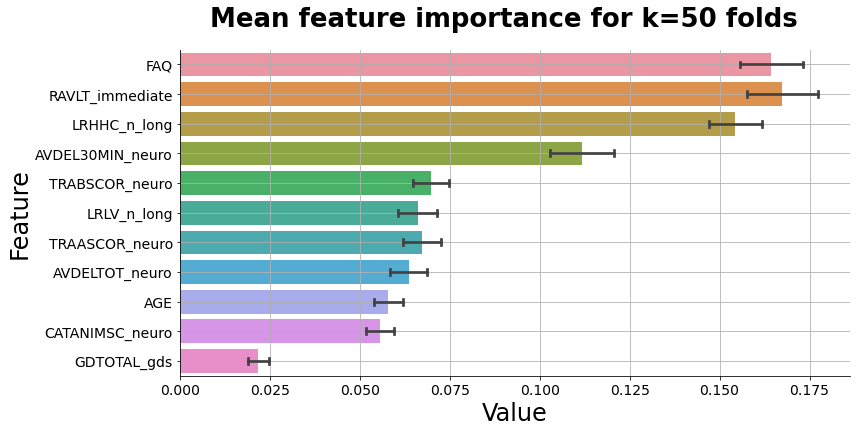

Mean featue importacne plot saved to:
		/home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF_-CV50-feat-importance-v.png



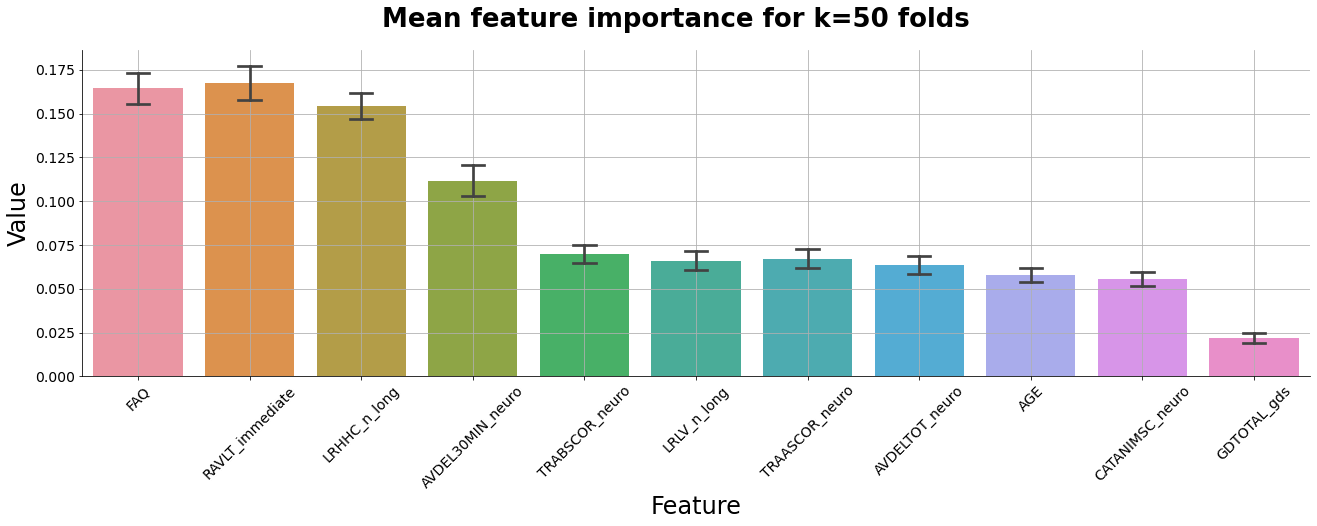

In [117]:
mrfbl.plot_mean_feature_importnce_cv(feat_import_CV, file_name_prefix=FILE_NAME_PREFIX,
                                     orientation='h',folds=FOLDS,figsize=(12,6), results_dir=RESULTS_DIR, save=True)

mrfbl.plot_mean_feature_importnce_cv(feat_import_CV, file_name_prefix=FILE_NAME_PREFIX,
                                     orientation='v', folds=FOLDS, figsize=(22,6), results_dir=RESULTS_DIR, save=True)

---

## CONFUSION MATRIX

#### NUMBER OF SUBJECTS IN EACH FOLD

In [118]:
if VERBOSE:
    print(f'Subjects in each fold:\n\t{valid_set_len_CV}\n')
    print(f'Meand fold length: {valid_set_len_CV.mean()}')

Subjects in each fold:
	[11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]

Meand fold length: 10.8


#### PLOT CONFUSION MATRIX

Confusion matrix saved to:

		/home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF_-conf-matrix-CV50.png



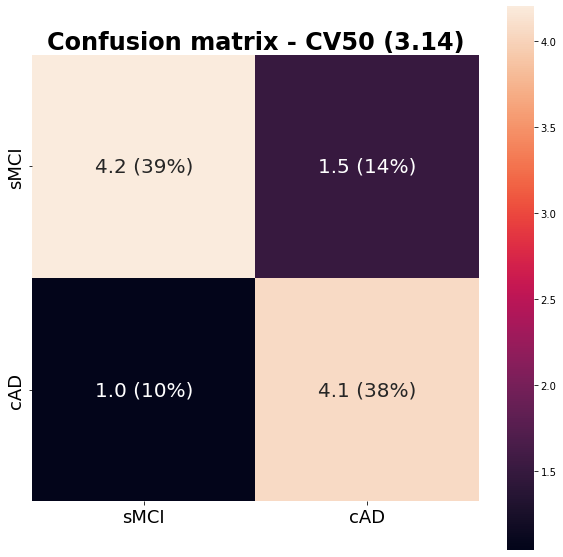

In [119]:
# mean of confusion matix over k=10 folds
conf_mat_mean = conf_matrix_CV.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_mat_mean_prc = conf_mat_mean / valid_set_len_CV.mean() * 100

mrfbl.plot_confusion_matrix_CV(conf_mat_mean, conf_mat_mean_prc, folds=FOLDS, file_name_number=FILE_NAME_NUMBER,
                                file_name_prefix=FILE_NAME_PREFIX, result_dir=RESULTS_DIR, save=True)

---

## CORELATION (OPTIONAL)

In [120]:
# cor = X_train.corr().abs()
# cor2 = np.tril(cor2,  k=0)

# cor2 = pd.DataFrame(np.where(cor2>0.4, cor, 0), columns=X_train.columns)
# cor2.set_index(X_train.columns, inplace=True)

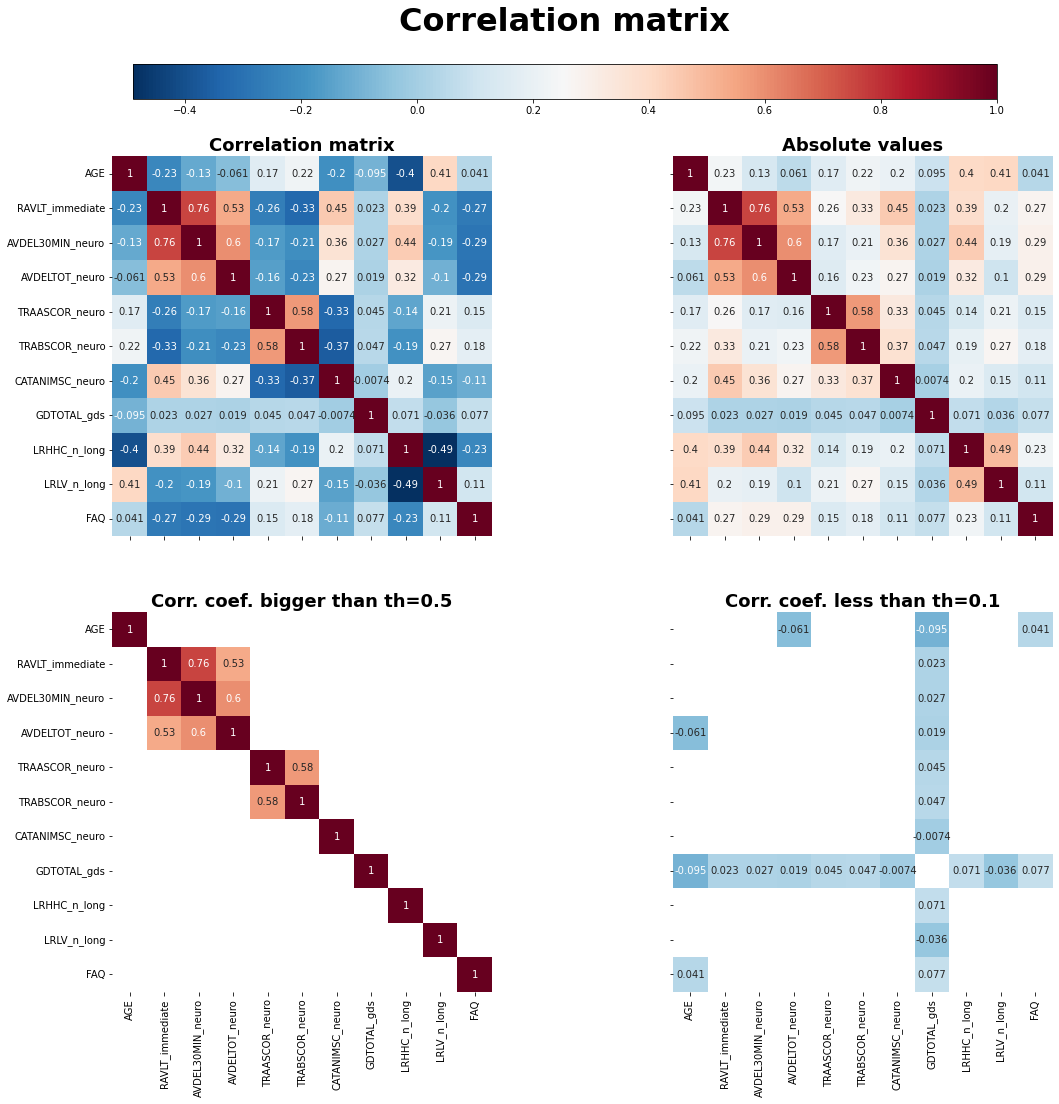

In [121]:
if VERBOSE:
    cor = X_train.corr()
    mn, mx = cor.values.min(), cor.values.max()
    cor_abs = X_train.corr().abs()    
    th1, th2 = 0.5, 0.1
    cor_th1 = cor[cor_abs>th1]
    cor_th2 = cor[cor_abs<th2]
    
    
    
    f,ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(20,16))
    sns.heatmap(cor, annot=True, cmap='RdBu_r', ax=ax[0,0], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_abs, annot=True, cmap='RdBu_r', ax=ax[0,1], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_th1, annot=True, cmap='RdBu_r', ax=ax[1,0], vmin=mn, vmax=mx, cbar=False)    
    sns.heatmap(cor_th2, annot=True, cmap='RdBu_r', ax=ax[1,1], vmin=mn, vmax=mx, cbar=False) 
    
    titles = ['Correlation matrix', 'Absolute values', f'Corr. coef. bigger than th={th1}', f'Corr. coef. less than th={th2}']
    for i,a in enumerate(ax.flat[:]):        
        a.set_aspect(aspect=1)
        a.set_title(titles[i], fontsize=18, fontweight='bold')
    
    
    cax = f.add_axes([0.2, 0.90, 0.6, 0.03])
    norm = plt.Normalize(mn, mx)
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])
    f.colorbar(sm, cax=cax, orientation='horizontal')

    plt.suptitle('Correlation matrix', fontsize=32, fontweight='bold')
    plt.subplots_adjust(wspace=0.01, top=0.85)
    #plt.tight_layout(rect=[0,0,1,0.85])

---

## VISUALIZATION (OPTIONAL)

In [122]:
# if VERBOSE:
#     #https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
#     # Extract single tree
#     estimator = clf.estimators_[4]

#     from sklearn.tree import export_graphviz
#     # Export as dot file
#     export_graphviz(estimator, out_file='tree.dot', 
#                     feature_names = X_train.columns,
#                     class_names = ['sMCi','cAD'],
#                     rounded = True, proportion = False, 
#                     precision = 2, filled = True)

#     # Convert to png using system command (requires Graphviz)
#     from subprocess import call
#     filename1 = FILE_NAME_PREFIX + '-tree.png'
#     filename2 = FILE_NAME_PREFIX + '-tree.pdf'

#     filepath1 = RESULTS_DIR/filename1
#     filepath2 = RESULTS_DIR/filename2

#     call(['dot', '-Tpng', 'tree.dot', '-o', filepath1, '-Gdpi=300'])
#     call(['dot', '-Tpdf', 'tree.dot', '-o', filepath2, '-Gdpi=600'])

#     # Display in jupyter notebook
#     display(Image(filename=filepath1))

#### REMOVE TEMPORARY `tree.png` and `tree.dot` FILES FROM THE CURRENT FOLDER

In [123]:
if 1:
    [f.unlink() for f in list(Path('.').glob("tree.*"))]

---

# TEST SET

---

#### TEST SETS VISUAL INSPECTIONS (OPTIONAL)

In [124]:
if VERBOSE:    
    tmp_df = pd.DataFrame.from_dict({'X_test_mean':X_test.mean().round(2), 'X_test_std':X_test.std().round(2)})
    
    print('"Original" Test set ')
    display(X_test.head())
    print('\nMean and std comparison')
    display(tmp_df)

"Original" Test set 


,AGE,RAVLT_immediate,AVDEL30MIN_neuro,AVDELTOT_neuro,TRAASCOR_neuro,TRABSCOR_neuro,CATANIMSC_neuro,GDTOTAL_gds,LRHHC_n_long,LRLV_n_long,FAQ
6,80.4,30.0,1.0,7.0,49.0,168.0,13.0,0.0,0.003638,0.026915,0.0
82,77.3,29.0,0.0,11.0,122.0,151.0,17.0,2.0,0.003343,0.076179,7.0
184,77.5,35.0,1.0,10.0,27.0,69.0,24.0,2.0,0.003149,0.023619,0.0
359,71.1,24.0,0.0,2.0,50.0,85.0,13.0,2.0,0.003729,0.021541,3.0
384,83.6,30.0,2.0,9.0,22.0,76.0,18.0,0.0,0.003700,0.019198,0.0



Mean and std comparison


,X_test_mean,X_test_std
AGE,73.50,7.35
RAVLT_immediate,33.97,8.73
AVDEL30MIN_neuro,3.59,3.42
AVDELTOT_neuro,10.68,3.41
TRAASCOR_neuro,41.10,20.35
TRABSCOR_neuro,116.42,65.70
CATANIMSC_neuro,17.04,4.82
GDTOTAL_gds,1.64,1.25
LRHHC_n_long,0.00,0.00
LRLV_n_long,0.03,0.01


---

## TRAIN THE RF CLASSIFIER AND PREDICT SUBGROPUS WITH THE USE OF UNSEEN TEST SET

In [125]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

#compare two ways of accuracy calucation
if VERBOSE:
    print(metrics.accuracy_score(y_test, y_test_pred).round(3))
    print(clf.score(X_test, y_test).round(3))

0.736
0.736


## TEST SET SCORES (F1, ACCURACY, RECALL, PRECISION)

In [56]:
# metrics
f1 = metrics.f1_score(y_test, y_test_pred)
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)

print(f'F1: {f1:.3f}')
print(f'ACC: {acc:.3f}')
print(f'RECALL: {recall:.3f}')
print(f'PREC: {prec:.3f}')

F1: 0.729
ACC: 0.750
RECALL: 0.723
PREC: 0.734


## CONUSIOM MATRIX

#### PREDICTIONS

In [57]:
bl_test_pred = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_test, y_test, y_test_pred)

cols2= []
filename = FILE_NAME_PREFIX + f'-TEST-predictions.csv'
bl_test_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_test_pred, cols2, filename,
                                                                              save=True, results_dir=RESULTS_DIR)


Subjects in the predictions table: 140

Predictions have been saved to a file:
		/home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF_-TEST-predictions.csv


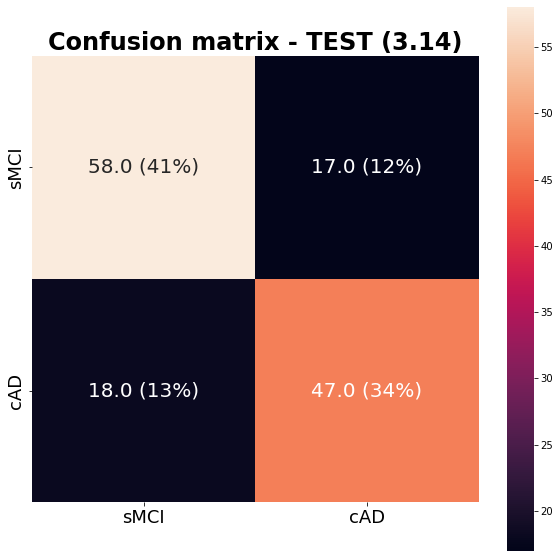

In [58]:
conf_matrix_test  = metrics.confusion_matrix(y_test, y_test_pred)    

# mean of test confusion matix
conf_mat_mean = conf_matrix_test.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100


mrfbl.plot_confusion_matrix_TEST(conf_matrix_test, conf_matrix_test_prc, file_name_number=FILE_NAME_NUMBER, file_name_prefix=FILE_NAME_PREFIX,
                                 save=True, results_dir=RESULTS_DIR)

## FEATURE IMPORTANCE

In [59]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print(f'Feature importance for the train set:\n\n{feature_imp.to_string()}')

Feature importance for the train set:

FAQ                 0.183396
RAVLT_immediate     0.176511
LRHHC_n_long        0.166057
AVDEL30MIN_neuro    0.094494
AVDELTOT_neuro      0.068248
AGE                 0.060173
TRAASCOR_neuro      0.059929
LRLV_n_long         0.059569
TRABSCOR_neuro      0.057464
CATANIMSC_neuro     0.050448
GDTOTAL_gds         0.023711


Mean featue importacne plot saved to:
		/home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF_-TEST-feat-importance-h.png



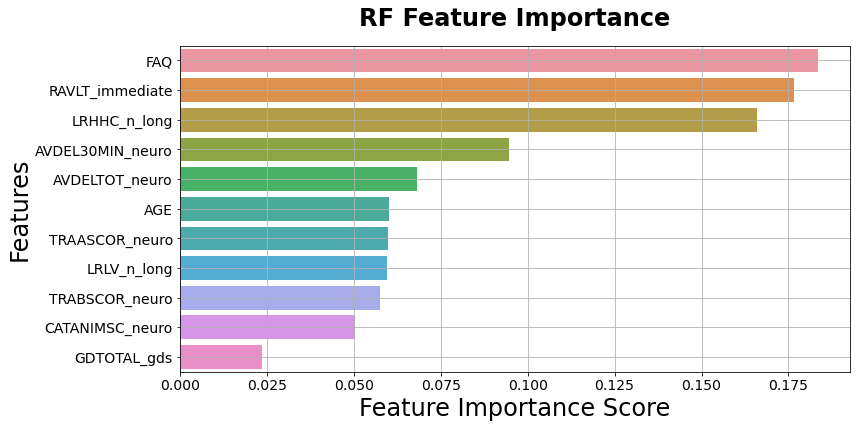

Mean featue importacne plot saved to:
		/home/ingrid/123/results/20211111/3.14_copy4Alexandra_K50_RF_-TEST-feat-importance-v.png



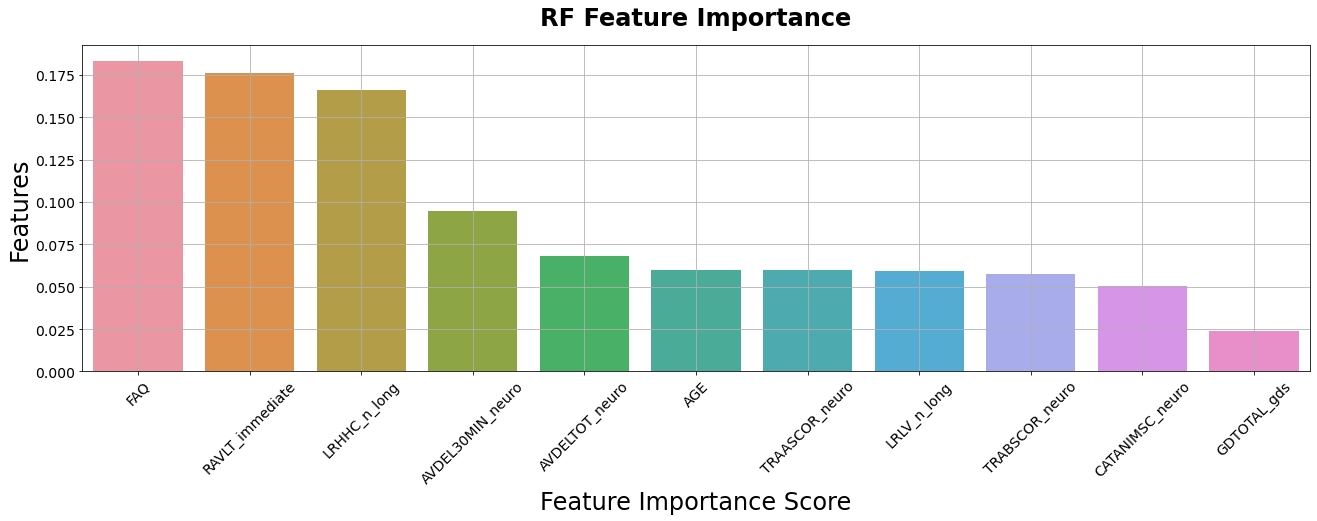

In [60]:
mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='h', figsize=(12,6), results_dir = RESULTS_DIR)

mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='v', figsize=(22,6), results_dir = RESULTS_DIR)

# Slice datafilen 

In [61]:
# This is to save the four dataframes with the excact subjects used in this model
# X_test.to_csv(RESULTS_DIR / '3.14_X_test.csv')
# X_train.to_csv(RESULTS_DIR / '3.14_X_train.csv')
# y_test.to_csv(RESULTS_DIR / '3.14_y_test.csv')
# y_train.to_csv(RESULTS_DIR / '3.14_y_train.csv')

Xy_train = pd.concat([X_train, y_train], axis=1).reindex(X_train.index)
Xy_train.to_csv(RESULTS_DIR / '3.14_Xy_train.csv')

Xy_test = pd.concat([X_test, y_test], axis=1).reindex(X_test.index)
Xy_test.to_csv(RESULTS_DIR / '3.14_Xy_test.csv')

# For hele datafilen brukt i analyse (altsaa samme som BL, but without subjects who had missing values)
Xy_train_test = frames = [Xy_train, Xy_test] 
Xy_train_test = pd.concat(frames)

Xy_train_test.to_csv(RESULTS_DIR / '3.14_Xy_test_train.csv')

# Slice datafilen 2 
This is to concatinate the two prediction tables created above to get a dataframe containing:
1. all features from main script with only  
2. extra column containing information about prediction (i.e. TN,FP, FN, TP) 

In [62]:
# Load prediction-files for CV k=50 
prediction_train = pd.read_csv ('../results/20211111/3.14_copy4Alexandra_K50_RF_-CV50-predictions.csv')
prediction_train.shape

(540, 140)

In [63]:
# Load prediction-files for TEST 
prediction_test = pd.read_csv ('../results/20211111/3.14_copy4Alexandra_K50_RF_-TEST-predictions.csv')
prediction_test.shape

(140, 138)

In [64]:
# Concatinate these the two prediction tables created above to create a dataframe containing:
# 1. all features from main script with only  
# 2. extra column containing information about prediction (i.e. TN,FP, FN, TP) 

prediction_full = pd.concat([prediction_train, prediction_test])
prediction_full.shape
prediction_full.to_csv(RESULTS_DIR / '3.14_copy4Alexandra_FULL-prediction.csv')

---

# FEATURE PERMUTATION WITH `eli5` 
([www](https://eli5.readthedocs.io/en/latest/overview.html))

In [65]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_split=3,
                       n_estimators=70, random_state=42)

#### TRAIN SET

In [66]:
# perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_train, y_train)
# eli5.show_weights(perm, feature_names = X_train.columns.tolist())

## TEST SET

In [67]:
perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(),)

Weight,Feature
0.1000 ± 0.0350,LRHHC_n_long
0.0843 ± 0.0291,FAQ
0.0643 ± 0.0511,RAVLT_immediate
0.0300 ± 0.0140,AVDEL30MIN_neuro
0.0257 ± 0.0265,AVDELTOT_neuro
0.0214 ± 0.0128,TRAASCOR_neuro
0.0157 ± 0.0190,TRABSCOR_neuro
0.0086 ± 0.0262,CATANIMSC_neuro
0.0029 ± 0.0146,AGE
0 ± 0.0000,GDTOTAL_gds


---

# PARTIAL DEPENDENCE PLOTS

#### 1D PDPs

In [68]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_split=3,
                       n_estimators=70, random_state=42)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


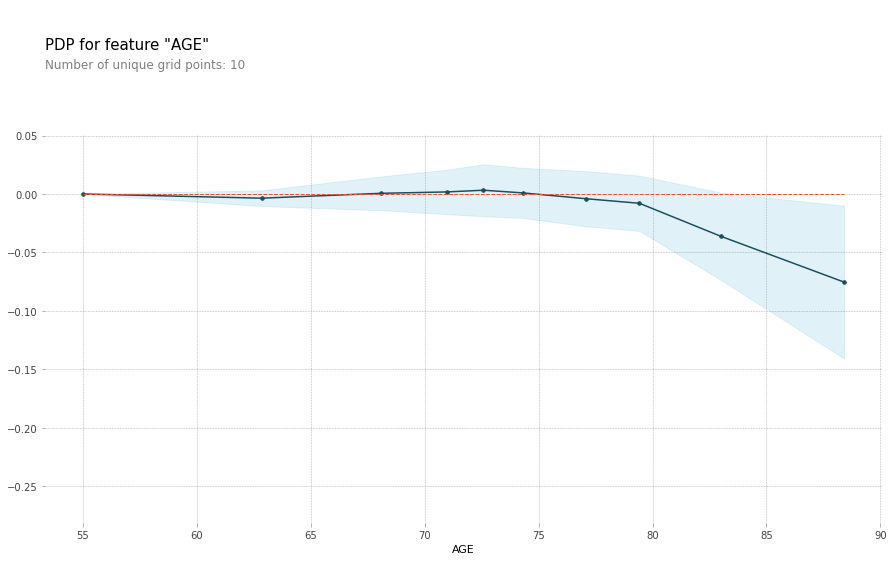

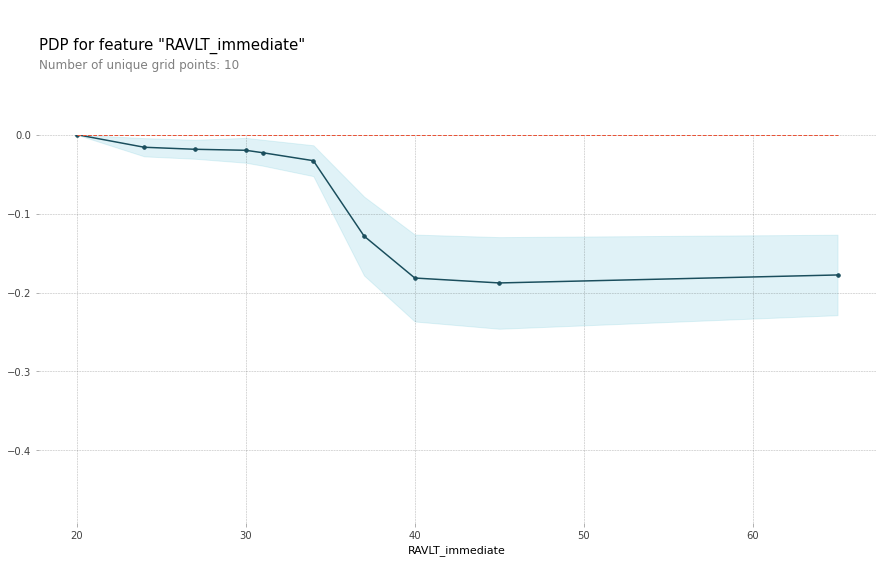

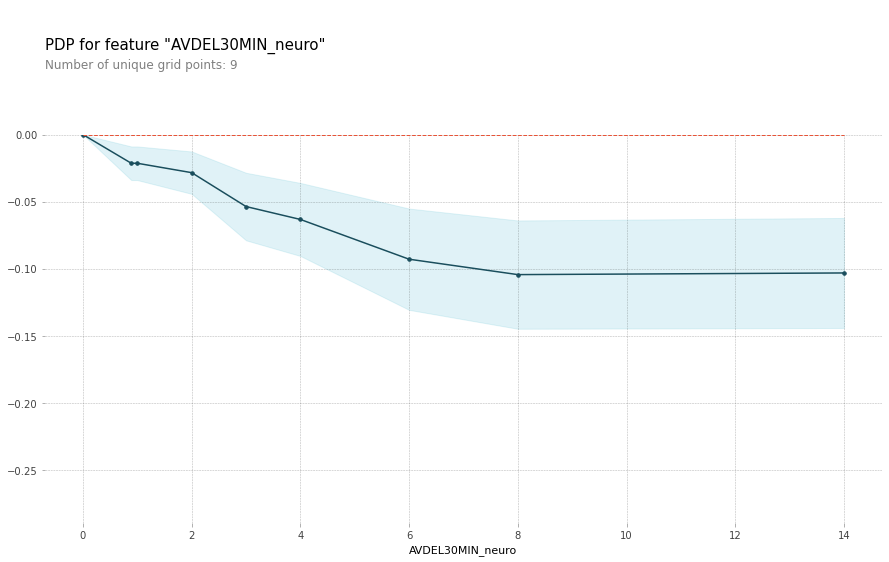

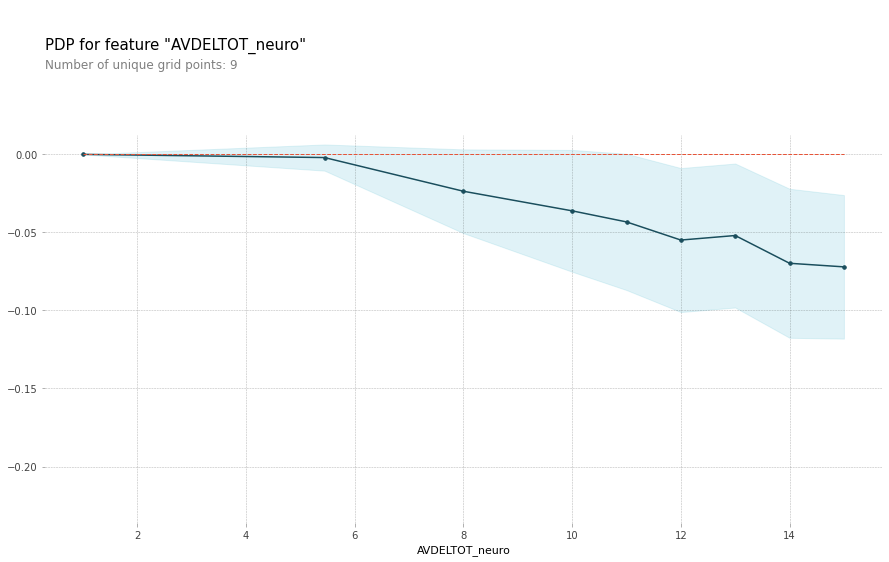

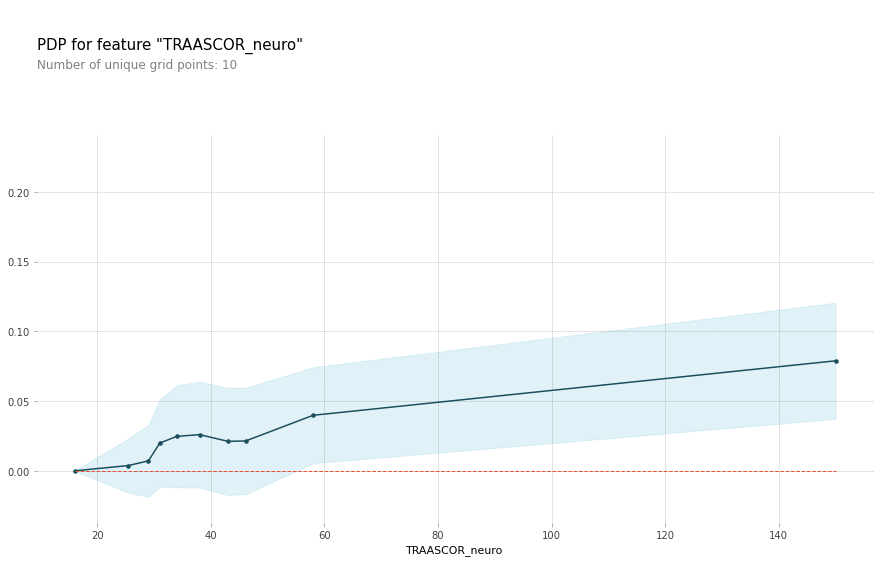

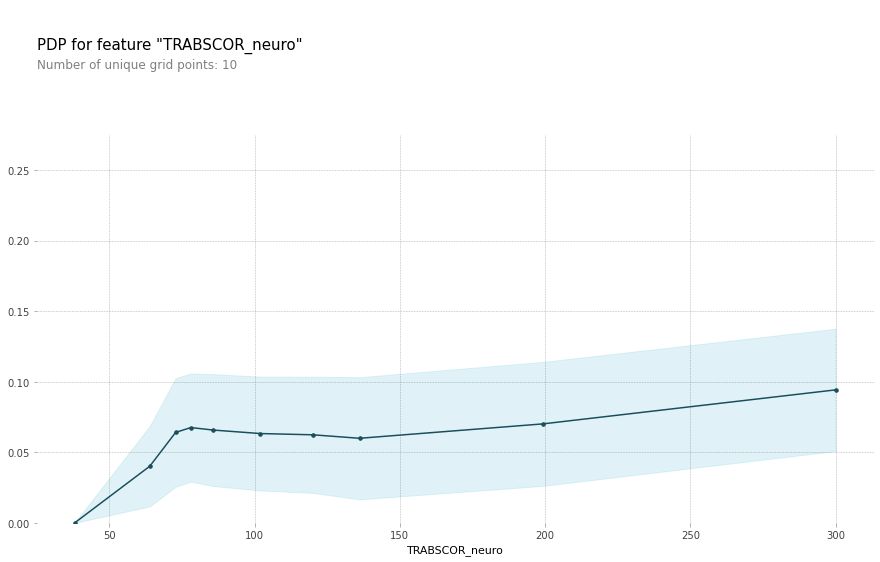

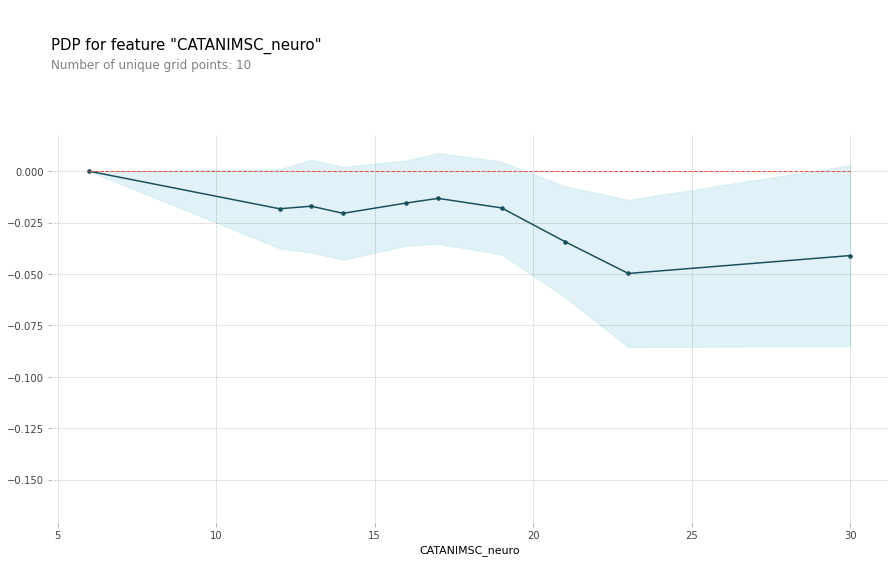

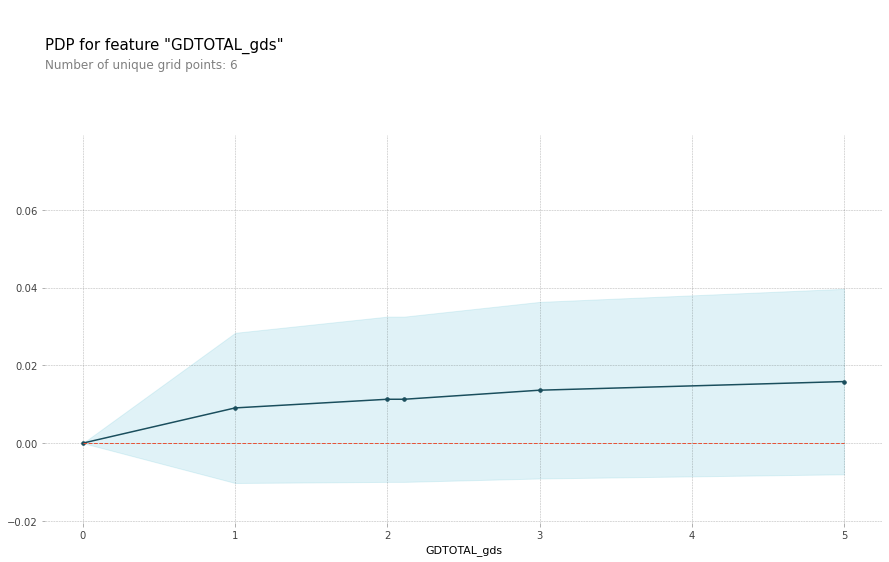

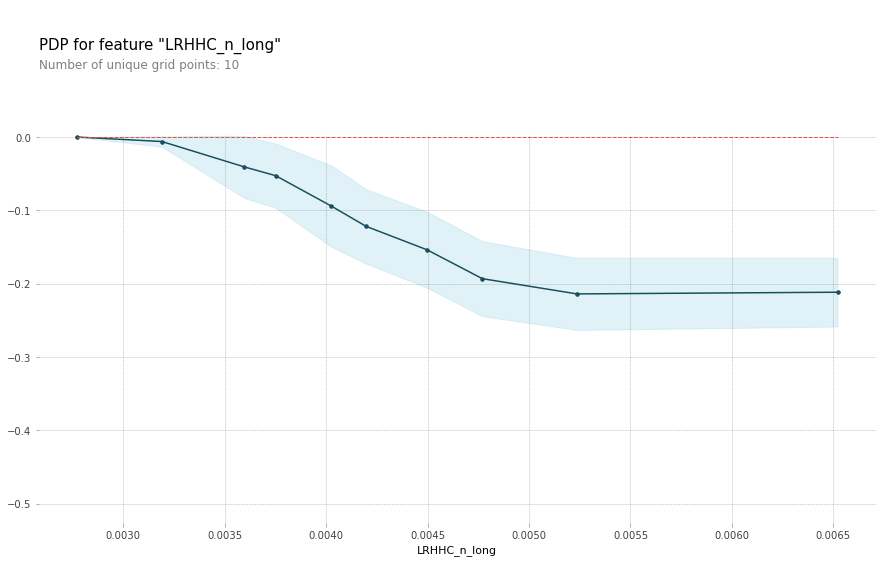

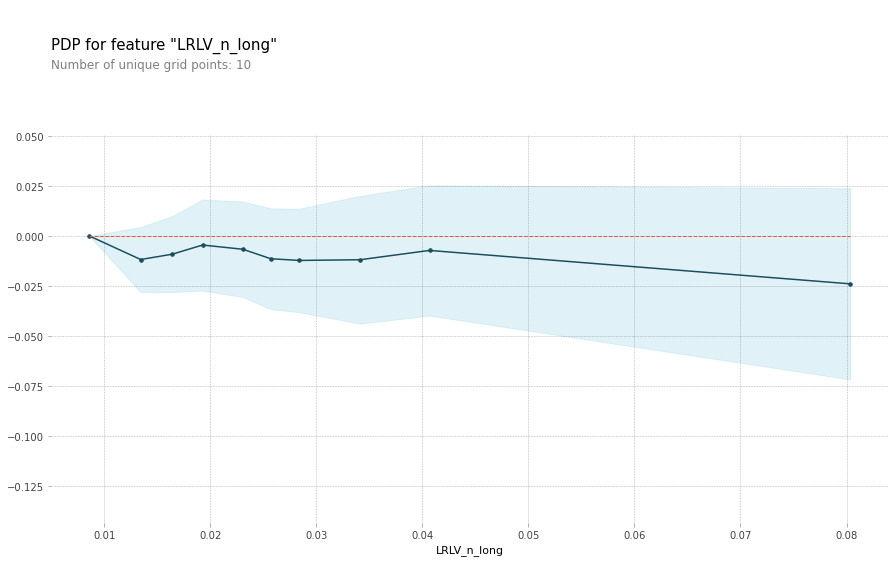

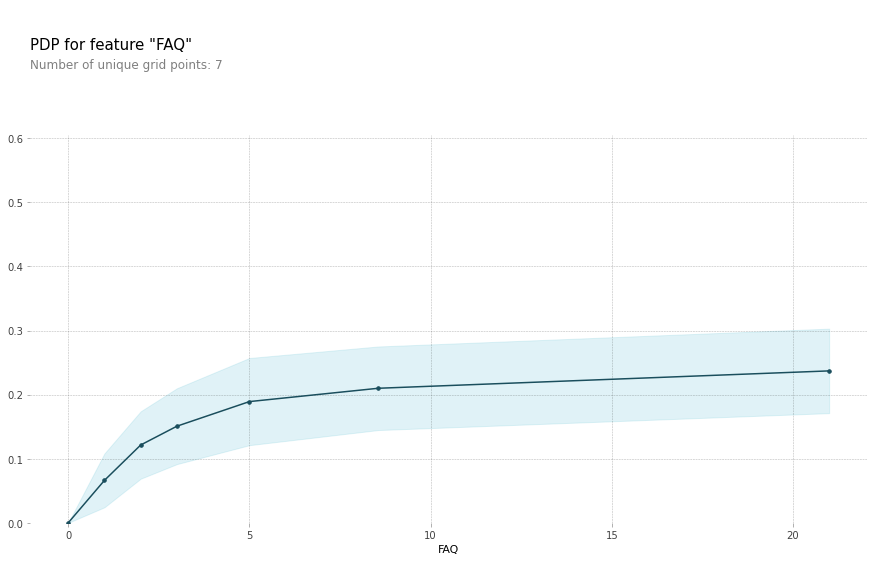

In [69]:
for feature in X_test.columns:
    pdp_goals = pdp.pdp_isolate(model=clf, dataset=X_test, model_features=X_test.columns.tolist(),
                                feature=feature)    
    pdp.pdp_plot(pdp_goals, feature)

    file_name_prefix_ext = f'{FILE_NAME_PREFIX}-pdp-TEST-{feature}.png'
    file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
    plt.savefig(file_name_prefix_path)

    plt.show()

#### 2D PDPs

In [70]:
# feat = ['LRHHC_n_long', 'AVDEL30MIN_neuro']
# interact  =  pdp.pdp_interact(model=clf, dataset=X_test, model_features=X_test.columns.tolist(), features=feat)
# pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=feat, plot_type='contour')
# plt.show()

In [71]:
# feat = ['LRHHC_n_long', 'AVDEL30MIN_neuro']
# interact  =  pdp.pdp_interact(model=clf, dataset=X_test, model_features=X_test.columns.tolist(), features=feat)
# pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=feat, plot_type='grid')
# plt.show()

---

# 3D partial dependence plots

Code copied from https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py

Changed features and titles obviously, but also 'est' to 'clf'

In [152]:
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features = ("LRHHC_n_long", "RAVLT_immediate")
pdp = partial_dependence(
    clf, X_train, features=features, kind="average", grid_resolution=20
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of risk for conversion\n"
    "on hippocampus volume and RAVLT immediate"
)
plt.subplots_adjust(top=0.9)
plt.show()

TypeError: partial_dependence() got an unexpected keyword argument 'kind'

<Figure size 432x288 with 0 Axes>

---

# PDP AND ICE PLOTS WITH SCIKIT-LEARN ([www](https://scikit-learn.org/stable/modules/partial_dependence.html))

In [70]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_split=3,
                       n_estimators=70, random_state=42)

In [71]:
print(FEATURES)

['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Subgroup_', 'Subgroup_num_', 'Usage_', 'Gender_num_']


#### PARTIAL DEPENDENCE PLOTS

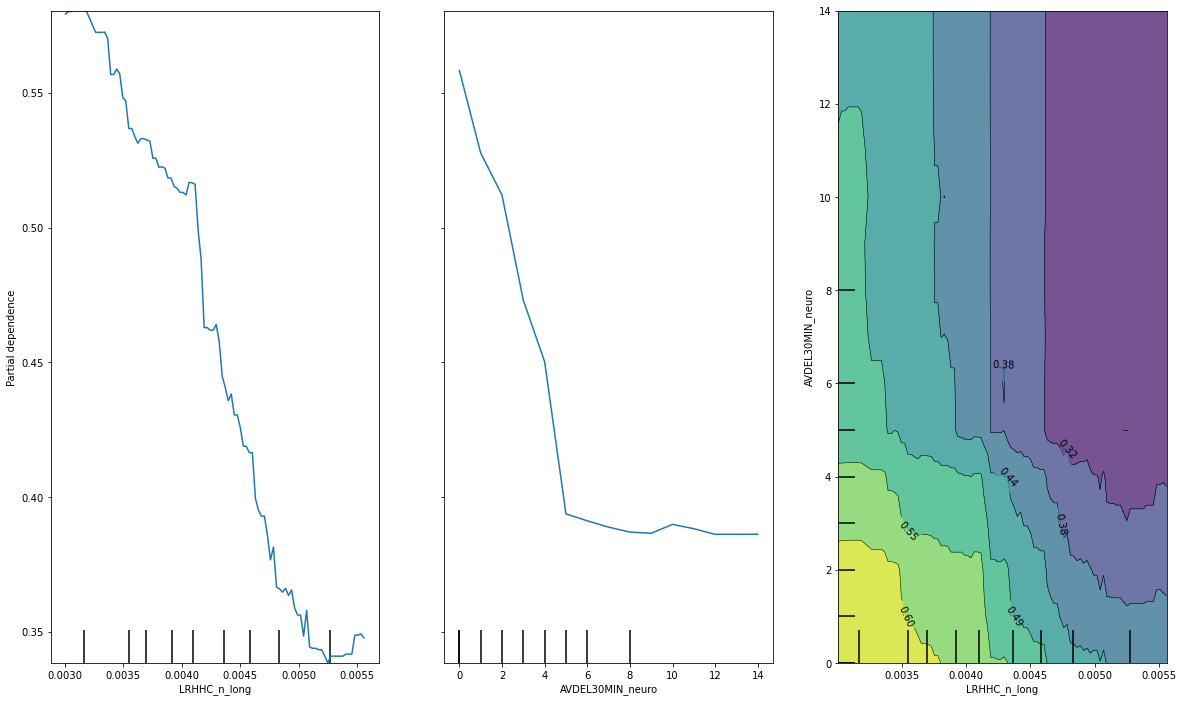

In [72]:
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test, ['LRHHC_n_long','AVDEL30MIN_neuro', ('LRHHC_n_long', 'AVDEL30MIN_neuro')], ax=ax, n_jobs=32)

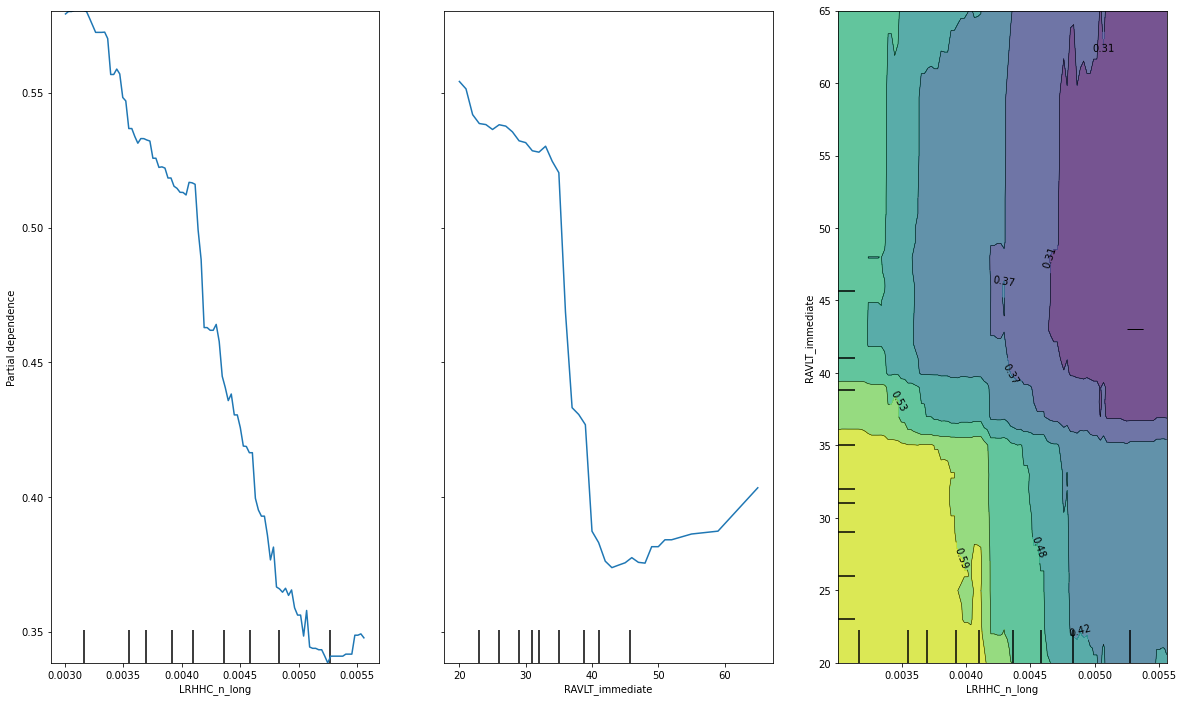

In [73]:
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test, ['LRHHC_n_long','RAVLT_immediate', ('LRHHC_n_long', 'RAVLT_immediate')], ax=ax, n_jobs=32)

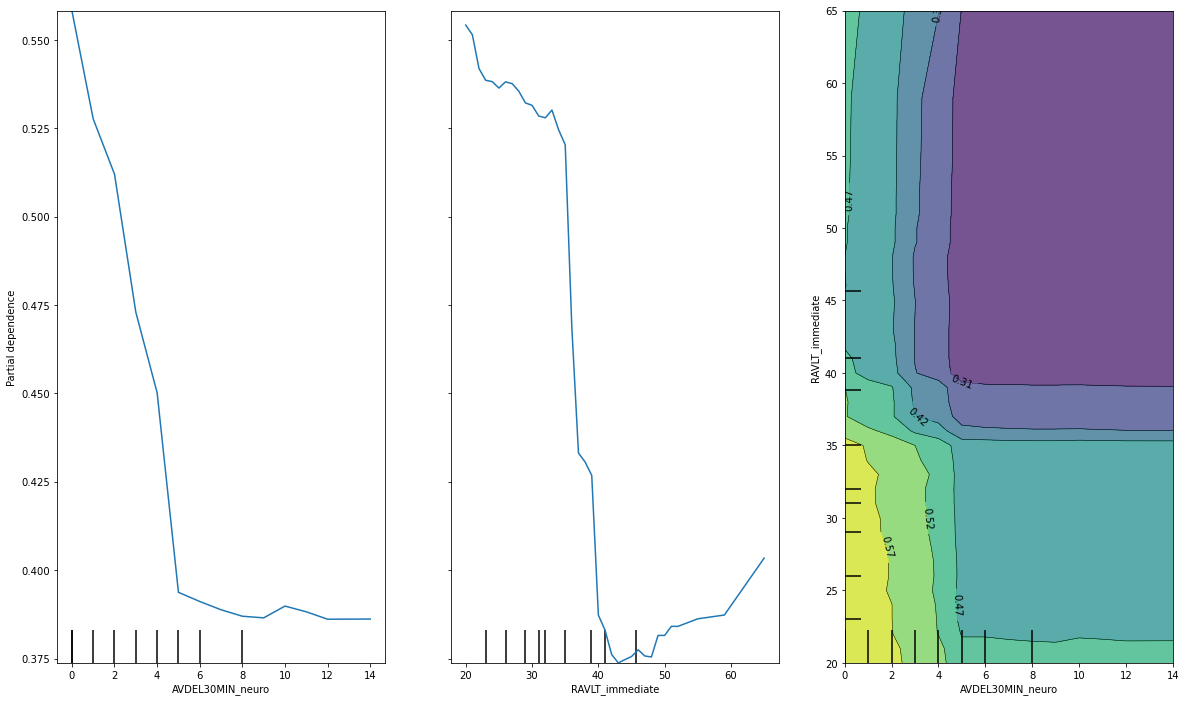

In [74]:
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test, ['AVDEL30MIN_neuro','RAVLT_immediate', ('AVDEL30MIN_neuro', 'RAVLT_immediate')], ax=ax, n_jobs=32)

#### INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS - TRAIN SET

In [75]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_split=3,
                       n_estimators=70, random_state=42)

TypeError: plot_partial_dependence() got an unexpected keyword argument 'kind'

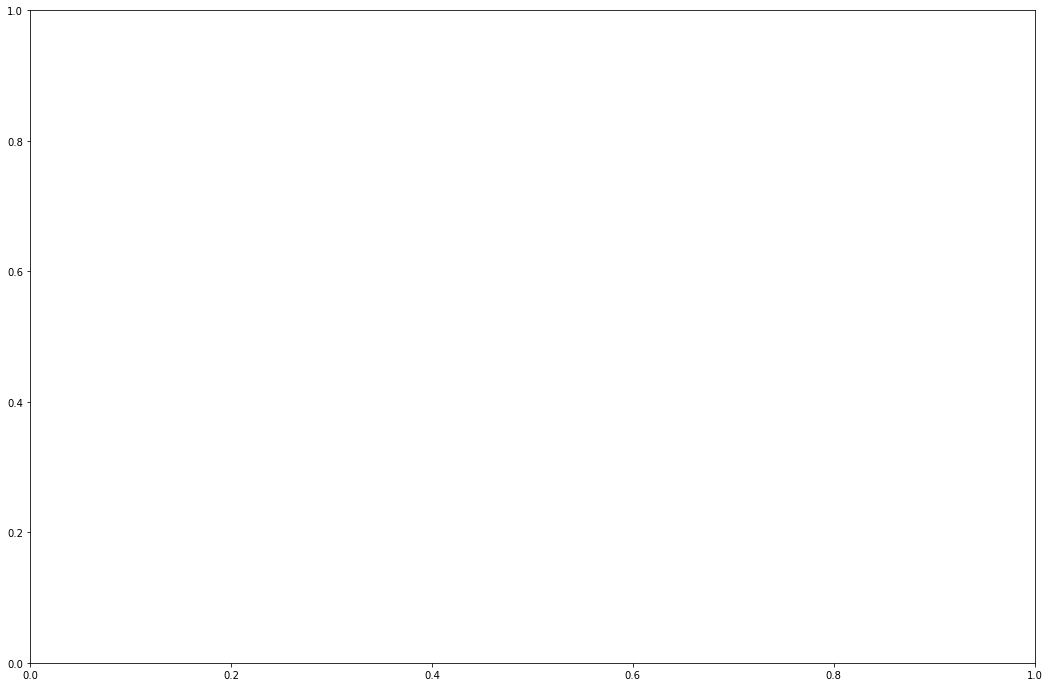

In [76]:
fig,ax = plt.subplots(figsize=(18,12),)
_=plot_partial_dependence(clf, X_train, features=X_train.columns, kind='both', ax=ax)

#### INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS - TEST SET

In [ ]:
fig,ax = plt.subplots(figsize=(18,12))
_=plot_partial_dependence(clf, X_test, features=X_test.columns, kind='both', ax=ax)


---

Code copied from https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py

Changed features and titles obviously, but also 'est' to 'clf'

In [144]:
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features = ("LRHHC_n_long", "RAVLT_immediate")
pdp = partial_dependence(
    clf, X_train, features=features, kind="both", grid_resolution=20
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of risk for conversion\n"
    "on hippocampus volume and RAVLT immediate"
)
plt.subplots_adjust(top=0.9)
plt.show()

TypeError: partial_dependence() got an unexpected keyword argument 'kind'

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure()

features = ("TRABSCOR_neuro", "RAVLT_immediate")
pdp = partial_dependence(
    clf, X_train, features=features, kind="average", grid_resolution=20
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of risk of conversion\n"
    "on hippocampus volume and RAVLT immediate"
)
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
# FEATURE PERMUTATION WITH GROUPS

In [ ]:
import mci_info as minfo
import mci_utils as mutils
import mci_freesurfer as mfs
import mci_rf_bl as mrfbl
import mci_permutation as mperm

In [ ]:
df, features = mperm.shuffle_features_with_groups(clf, X_test, y_test,
                                                  precission=3,
                                                  verbose=True,
                                                  random_state=RANDOM_STATE,
                                                  repetitions=200,
                                                  sortBy='f1',
                                                  ascending=False,
                                                  groups=[['RAVLT_immediate','AVDEL30MIN_neuro', 'AVDELTOT_neuro'],
                                                          ['TRAASCOR_neuro','TRABSCOR_neuro']])
display(df)
mperm.plot_permuted_features(df,
                             file_name_prefix=FILE_NAME_PREFIX,
                             type='shuffle',
                             title_suffix='Shuffled 200 times',
                             save=False,
                             results_dir=RESULTS_DIR,
                             figsize=(18,8)                             
                            )
mperm._print_group_names(features)

## Playing with SHAP 

In [ ]:
#importing shap package
import shap
shap.initjs()

In [ ]:
# Printing shape of data 
print("Training features shape:", X_train.shape)
print("Training target shape:", X_test.shape)
print()
print("Test features shape:",y_train.shape)
print("Test target shape",y_test.shape)

In [ ]:
explainer = shap.Explainer(clf)
shap_test = explainer(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print("*****************************************")
print(f"Sample shap values:\n{shap_test[0]}")

Explanations regarding the cell abode:
- The length of shap_test is 139 because it contains a record for each test instance (i.e. patient in TEST set) 
- Built into shap_test there are three metrics (NB! Displayed here for subject with index==0 is displayed)
    - **shap_test[0].base_values is Base values for target**: this is also known as the expected value (explainer.expected_value), tells us the probability of for each class (for regression problems), whereas in classification models this tells us the probability for each class. We will focus on the positive class (i.e. y == 1, convertion to AD. Not to self: finne ut hva det betyre å "focuse on the positive class". 
    - **shap_test[0.data**: value for each feature]
    - **shap_test[0].values**: Shap values for each features

In [ ]:
print(f"Expected value: {explainer.expected_value[1]:.2f}")
print(f"Average target value (training data): {y_train.mean():.2f}")
print(f"Base value: {np.unique(shap_test.base_values)[0]:.2}")

In [ ]:
(shap_test.data == X_test).describe()

In [ ]:
# Converting to data frame
pd.DataFrame(shap_test.data, columns=shap_test.feature_names, 
             index=X_test.index)

In [ ]:
shap_df = pd.DataFrame(shap_test.values[:,:,0],
                       columns=shap_test.feature_names,
                       index=X_test.index)
shap_df

In [ ]:
# We can see the shap values by feature for each record. If we add these shap values to the expected value, we will get the prediction:
# Dette skal (i følge notebooken) være |True| ikke |False|, men troooooor kanskje det er relatert til at notboken i dette tilfellet snakket om regression og ikke klassifikasjon. 
np.isclose(clf.predict(X_test), 
           explainer.expected_value[0] + shap_df.sum(axis=1))

In [ ]:
# The left subplot shows the mean absolute shap value for each feature whereas the right subplot shows the distribution of the shap values by feature. 
# One takeaway from these graphs is that RAVLT_immediate has the biggest contribution among the 12 features being used.


columns = shap_df.apply(np.abs).mean()\
                 .sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(11,4))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
            ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

In [ ]:
shap.summary_plot(shap_test)

In [ ]:
print(type(X_train))

In [ ]:
numpy_array = X_train.to_numpy()

In [ ]:
shap.plots.bar(numpy_array)

In [ ]:
shap.summary_plot(numpy_array)

In [ ]:
X_train.head()

In [ ]:
array = X_train.to_records(index=True)

In [ ]:
#print(array)

---

### EXPLORING THE CHARACTERISTICS WITH THE FOUR CLASSES (TN, FP, FN, TP) 

In [ ]:
# This datafile contains data from participants in test set ('Usage_'==test), as well well how they were classified. 
predictions_bl = pd.read_csv('../results/20211111/3.12_RF-TEST-predictions.csv')
predictions_bl.head()

In [ ]:
predictions_bl.columns

### Stealing (and modifiing) Mareks function for box and violin plots

In [ ]:
def plot_violin_box_feature_vs_classification(df, feature_name='AGE', **kw):
    """
    Plots violin and box plot figures of feature vs. Classification 
    
    Changes: Additional parameter: title, by deafault figure title was assumed as feature name.
            There is possibility to set any title.
            
    
    Parameters:
    -------------
    df - data frame, a table to take features from (a pandas dataframe),
    feature_name - name of a feature to plot (a string, default: 'AGE')
    
    Optional:
    ----------
    title - a figure title (a string, dafault: feature_name vs. Subgroup)
    points - weather or not to plot jitter dots (a boolean value, default:True)
    figsize - figure size (a tuple with size, deafault: (16,8))
    
    
    x_label - x axis label (a string, default: 'Subgroup')
    x_label_size - x label font size (an inteager, default: 28)
    x_label_labelpad - x label distance from axis (an inteager, default:20)
    
    y_label - y axis label (a string, default: feature_name)
    y_label_size - y label font size (an inteager, default: 28)
    y_label_labelpad - y label distance from axis (an inteager, default:20)
    
    grid_on - turn on/off a grid (a boolean value, default: True)
    
    subplot_adj - adjust subplot spaces (a list with float numbers).
                Usage:  (left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2,  hspace=0.35)
                Parameters:
                - sub_left
                - sub_bottom
                - sub_right
                - sub_top
                - sub_wspace
                - sub_hspace
                
    
    Created 2020.11.15 / Updated 2021.03.04
    """    
    title = kw.get('title', f'{feature_name} vs. Subgroup')
    points = kw.get('points', True)
    figsize = kw.get('figsize', (16,8))
    
    x_label = kw.get('x_label', 'Subgroup')
    x_label_size = kw.get('x_label_size', 28)
    x_label_labelpad = kw.get('x_label_labelpad', 10)
    
    y_label = kw.get('y_label', feature_name)
    y_label_size = kw.get('y_label_size', 28)
    y_label_labelpad = kw.get('y_label_labelpad', 10)
    
    # (left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2,  hspace=0.35)
    sub_left = kw.get('sub_left', 0.05)
    sub_bottom = kw.get('sub_bottom', 0.05)
    sub_right = kw.get('sub_right', 0.95)
    sub_top = kw.get('sub_top', 0.9)
    sub_wspace = kw.get('sub_wspace', 0.05)
    sub_hspace = kw.get('sub_hspace', 0.05)
    
    figSaveName = kw.get('figSaveName', '')
    
    
    grid_on = kw.get('grid', True)
        
    
    #title = title if title else f'{feature_name} vs. Subgroup'
    violin, ax = plt.subplots(1,2, figsize=figsize, sharex=True, sharey=True)
    
    _ = plt.suptitle(title, fontsize=26, weight='bold')
    
    _ = sns.violinplot(x='CM_pred_', y=feature_name, hue='PTGENDER', data=df, split=True, ax=ax[0])
    if points:
        _ = sns.stripplot(x="CM_pred_", y=feature_name, hue='PTGENDER', data=df, dodge=True, palette='dark',ax=ax[0])
        
    _ = sns.boxplot(x='CM_pred_', y=feature_name, hue='PTGENDER', data=df,  ax=ax[1])
    

    for a in ax:
        a.set_xlabel(x_label, fontsize=x_label_size, weight='bold', labelpad=x_label_labelpad)
        a.set_ylabel(y_label, fontsize=y_label_size, weight='bold', labelpad=y_label_labelpad)
        
        a.tick_params(axis='both', which='major', labelsize=20)
        a.tick_params(axis='both', which='minor', labelsize=20)
        
        handles, labels = a.get_legend_handles_labels()
        a.legend(handles[0:2], labels[0:2],loc=8, prop={'size': 16})        
        a.grid(grid_on)    
        
    ax[1].set(ylabel=None)
    

### Plotting

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='RAVLT_immediate', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='LRHHC_n_long', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='AVDEL30MIN_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='TRABSCOR_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='CATANIMSC_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='AVDELTOT_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='AGE', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='TRAASCOR_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='ANARTERR_neuro', points=True)

In [ ]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='GDTOTAL_gds', points=True)

In [ ]:
matplotlib.pyplot.bar(, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)

------

### Descriptive statistic for sMCI and cAD subgrup

In [ ]:
pwd

In [ ]:
Xy_train = pd.read_csv('../results/20211111/3.12_Xy_train.csv')

In [ ]:
Xy_train.head()